# Development of Algorithms for ERDDAP Dataset from ONC Ferry Data

Figuring out how to transform a day's ONC ferry data into
a netCDF file that is part of an ERDDAP dataset:

* create a boolean mask that differentiates observations collected
while the ferry is was on a crossing from those collected while it was
in berth at a terminal
* assign a crossing number to each on-crossing observation
* filter the ONC data to include only `qaqcFlag == 1` samples
* remove the `qaqcFlag` arrays as variable attributes
* aggregate the data into 1 minute time bins;
mean, variance, and count for each variable in each time bin
* store dataset as netCDF file
* generate ERDDAP `/opt/tomcat/content/erddap/datasets.xml` fragment

In [1]:
from collections import OrderedDict
import os
from types import SimpleNamespace

import arrow
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import data_tools
from salishsea_tools.places import PLACES

In [2]:
%matplotlib inline

Access to the ONC web services requires a user token which you can generate on the 
`Web Services API` tab of your [ONC account profile page](http://dmas.uvic.ca/Profile).
I have stored mine in an environment variable so as not to publish it to the world
in this notebook.

In [4]:
TOKEN = os.environ['ONC_USER_TOKEN']

## Data of Interest

Consultation with Rich and Susan resulted in this list of data of interest:

* Navigation
  *  lat/lon
* Thermosalinograph
   * temperature
   * conductivity
   * salinity
* Oxygen Sensor
   * saturation
   * corrected concentration
* Turbidity, Chlorophyll and Fluorescence
  * CDOM fluorescence
  * chlorophyll
  * turbidity
   
Only available on Tsawwassen - Duke Point route:

* CO2 Sensor
  * partial pressure
  * linearized concentration
  
Need to identify when ferries are pn a crossing vs. when they are in a berth
(for loading/unloading, etc.).

Also need to identify separate crossings.

## Ferry Location Data

Request a day's worth of ferry location (longitude, latitude) data
and parse them into an `xarray.Dataset`:

In [5]:
onc_station = 'TWDP'
ferry_route_name = 'Tsawwassen - Duke Point'
onc_station_description = 'Mobile Platforms, British Columbia Ferries, Tsawwassen - Duke Point'
data_date = arrow.get('2017-08-27')

In [6]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station=f'{onc_station}.N1', 
    deviceCategory='NAV',
    sensors='longitude,latitude',
    dateFrom=data_tools.onc_datetime(f'{data_date.format("YYYY-MM-DD")} 00:00', 'utc'),
)

nav_data = data_tools.onc_json_to_dataset(onc_data)

In [7]:
nav_data

<xarray.Dataset>
Dimensions:     (sampleTime: 86396)
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.076000 ...
Data variables:
    latitude    (sampleTime) float64 49.2 49.2 49.2 49.2 49.2 49.2 49.2 49.2 ...
    longitude   (sampleTime) float64 -123.9 -123.9 -123.9 -123.9 -123.9 ...
Attributes:
    dateFrom:            2017-08-27T00:00:00.000Z
    dateTo:              None
    deviceCategory:      NAV
    nextDateFrom:        2017-08-28T00:00:00.077Z
    outputFormat:        None
    rowLimit:            None
    sensors:             longitude,latitude
    station:             TWDP.N1
    totalActualSamples:  172792

Resample longitudes and latitudes to their mean values in 1 minute intervals,
and rename the time variable:

In [8]:
lons = (
    nav_data.longitude
        .resample('1Min', 'sampleTime', how='mean')
        .rename({'sampleTime': 'time'})
)

lats = (
    nav_data.latitude
        .resample('1Min', 'sampleTime', how='mean')
        .rename({'sampleTime': 'time'})
)

print(lons)
print(lats)

<xarray.DataArray 'longitude' (time: 1440)>
array([-123.878813, -123.884423, -123.889459, ..., -123.82916 , -123.837211,
       -123.845259])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
<xarray.DataArray 'latitude' (time: 1440)>
array([ 49.200051,  49.196264,  49.192171, ...,  49.213486,  49.211747,
        49.209974])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...


### On-Crossing Data Mask

Calculate a boolean mask data array that indicates
when the ferry is on a crossing vs. when it is in a berth

In [9]:
tsw = PLACES['Tsawwassen']
duke_pt = PLACES['Duke Pt.']
tsw, duke_pt

({'in berth radius': 0.0015, 'lon lat': (-123.132722, 49.006165)},
 {'in berth radius': 0.002,
  'lon lat': (-123.89095676900132, 49.16340592936349)})

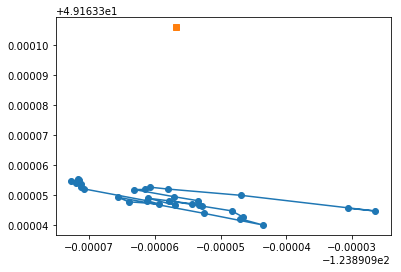

In [10]:
fig, ax = plt.subplots(1, 1)
n_pts = slice(14, 45)
ax.plot(lons[n_pts], lats[n_pts], 'o-')
ax.plot(duke_pt['lon lat'][0], duke_pt['lon lat'][1], 's')

The nominal Duke Point ferry terminal location from `PLACES['Duke Pt.']`
is clearly not accurate enough for our `in_berth` mask calculation.
Instead,
we'll use the mean of the cluster of points when the ferry was in-berth.

In [11]:
dp_data = (lons[15:44].mean(), lats[15:44].mean())
dp_data

(<xarray.DataArray 'longitude' ()>
 array(-123.8909579704301), <xarray.DataArray 'latitude' ()>
 array(49.16334864638026))

Plotting the `dp_data` location on Google Maps,
and playing with offsets leads to choosing 0.002°
as a satisfactory "in-berth" radius to use.

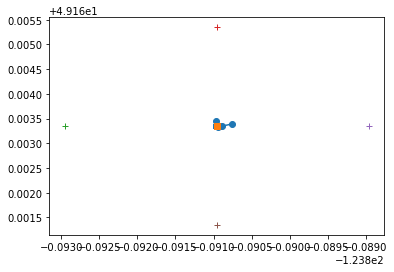

In [12]:
dp_radius = 0.002
fig, ax = plt.subplots(1, 1)
n_pts = slice(11, 47)
ax.plot(lons[n_pts], lats[n_pts], 'o-')
ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

In [13]:
in_berth = np.logical_and(
    np.logical_and(
        lons[n_pts] > (dp_data[0] - dp_radius), 
        lons[n_pts] < (dp_data[0] + dp_radius)),
    np.logical_and(
        lats[n_pts] > (dp_data[1] - dp_radius), 
        lats[n_pts] < (dp_data[1] + dp_radius))
    )
in_berth

<xarray.DataArray 'longitude' (time: 36)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:11:00 2017-08-27T00:12:00 ...

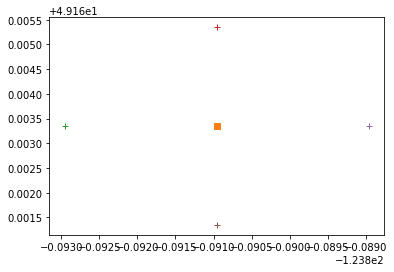

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(lons[n_pts][~in_berth], lats[n_pts][~in_berth], 'o')
ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

Repeating the process for the Tsawwassen terminal:

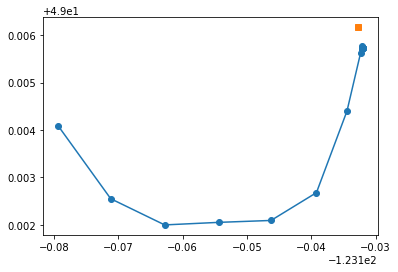

In [15]:
fig, ax = plt.subplots(1, 1)
n_pts = slice(1313, 1349)
ax.plot(lons[n_pts], lats[n_pts], 'o-')
ax.plot(tsw['lon lat'][0], tsw['lon lat'][1], 's')

The nominal Tsawwassen ferry terminal location from `PLACES['Tsawwassen']`
is clearly not accurate enough for our `in_berth` mask calculation.
Instead,
we'll try the mean of the cluster of points when the ferry was in-berth.

In [16]:
tsw_data = (lons[1314:1348].mean(), lats[1314:1348].mean())
tsw_data

(<xarray.DataArray 'longitude' ()>
 array(-123.13545928470997), <xarray.DataArray 'latitude' ()>
 array(49.00517862700571))

Plotting the `tsw_data` location on Google Maps,
and playing with offsets leads to choosing a better lon/lat,
and 0.0015° as a satisfactory "in-berth" radius to use.

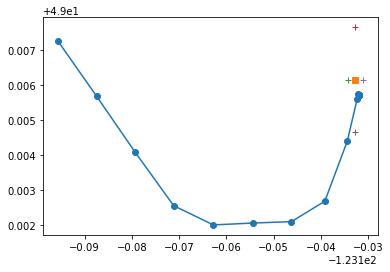

In [17]:
tsw_data = (-123.132722, 49.006165)
tsw_radius = 0.0015
fig, ax = plt.subplots(1, 1)
n_pts = slice(1309, 1351)
ax.plot(lons[n_pts], lats[n_pts], 'o-')
ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

In [18]:
in_berth = np.logical_or(
    np.logical_and(
        np.logical_and(
            lons[n_pts] > (dp_data[0] - dp_radius), 
            lons[n_pts] < (dp_data[0] + dp_radius)),
        np.logical_and(
            lats[n_pts] > (dp_data[1] - dp_radius), 
            lats[n_pts] < (dp_data[1] + dp_radius))
    ),
    np.logical_and(
        np.logical_and(
            lons[n_pts] > (tsw_data[0] - tsw_radius), 
            lons[n_pts] < (tsw_data[0] + tsw_radius)),
        np.logical_and(
            lats[n_pts] > (tsw_data[1] - tsw_radius), 
            lats[n_pts] < (tsw_data[1] + tsw_radius))
    )
)
in_berth

<xarray.DataArray 'longitude' (time: 42)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False, False,
       False, False], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T21:49:00 2017-08-27T21:50:00 ...

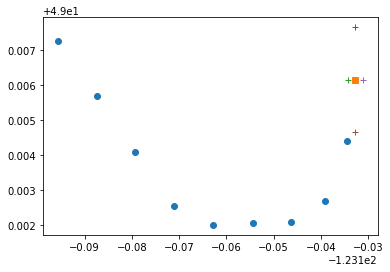

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(lons[n_pts][~in_berth], lats[n_pts][~in_berth], 'o')
ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

A function that calculates the `on_crossing` mask:

In [20]:
def on_crossing(lons, lats, terminal1, terminal2, n_pts=slice(0, None)):
    in_berth = np.logical_or(
        np.logical_and(
            np.logical_and(
                lons[n_pts] > (terminal1.lon - terminal1.radius), 
                lons[n_pts] < (terminal1.lon + terminal1.radius)),
            np.logical_and(
                lats[n_pts] > (terminal1.lat - terminal1.radius), 
                lats[n_pts] < (terminal1.lat + terminal1.radius))
        ),
        np.logical_and(
            np.logical_and(
                lons[n_pts] > (terminal2.lon - terminal2.radius), 
                lons[n_pts] < (terminal2.lon + terminal2.radius)),
            np.logical_and(
                lats[n_pts] > (terminal2.lat - terminal2.radius), 
                lats[n_pts] < (terminal2.lat + terminal2.radius))
        )
    )
    return np.logical_not(in_berth)

dp_terminal = SimpleNamespace(lon=dp_data[0], lat=dp_data[1], radius=dp_radius)
tsw_terminal = SimpleNamespace(lon=tsw_data[0], lat=tsw_data[1], radius=tsw_radius)
on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

<xarray.DataArray 'longitude' (time: 42)>
array([False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T21:49:00 2017-08-27T21:50:00 ...

The dataset begins with the end of a crossing:

<xarray.DataArray 'time' ()>
array(1503792000000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27 <xarray.DataArray 'time' ()>
array(1503792480000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T00:08:00
on-crossing minutes:  9
in-berth minutes:  7


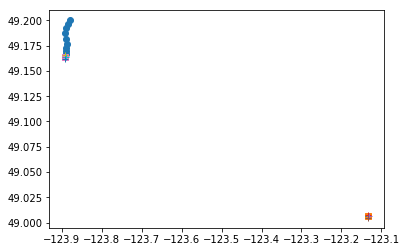

In [21]:
fig, ax = plt.subplots(1, 1)

n_pts = slice(0, 16)
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

ax.plot(lons[n_pts][on_crossing_mask], lats[n_pts][on_crossing_mask], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

print(lons.time[n_pts][on_crossing_mask][0], lons.time[n_pts][on_crossing_mask][-1])
print('on-crossing minutes: ', lons.time[n_pts][on_crossing_mask].size)
print('in-berth minutes: ', lons.time[n_pts][~on_crossing_mask].size)
total_on_crossing_minutes, total_in_berth_minutes = 0, 0
total_on_crossing_minutes += lons.time[n_pts][on_crossing_mask].size
total_in_berth_minutes += lons.time[n_pts][~on_crossing_mask].size

That is followed by a southbund crossing:

<xarray.DataArray 'time' ()>
array(1503794880000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T00:48:00 <xarray.DataArray 'time' ()>
array(1503801660000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T02:41:00
on-crossing minutes:  114
in-berth minutes:  35


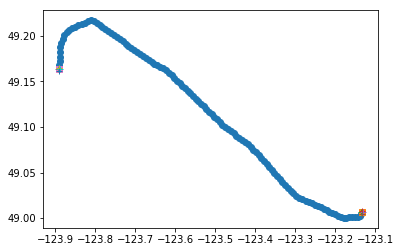

In [22]:
fig, ax = plt.subplots(1, 1)

n_pts = slice(16, 165)
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

ax.plot(lons[n_pts][on_crossing_mask], lats[n_pts][on_crossing_mask], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

print(lons.time[n_pts][on_crossing_mask][0], lons.time[n_pts][on_crossing_mask][-1])
print('on-crossing minutes: ', lons.time[n_pts][on_crossing_mask].size)
print('in-berth minutes: ', lons.time[n_pts][~on_crossing_mask].size)
total_on_crossing_minutes += lons.time[n_pts][on_crossing_mask].size
total_in_berth_minutes += lons.time[n_pts][~on_crossing_mask].size

There is a long time gap until the next crossing northbound:

<xarray.DataArray 'time' ()>
array(1503803640000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T03:14:00 <xarray.DataArray 'time' ()>
array(1503860880000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T19:08:00
on-crossing minutes:  560
in-berth minutes:  430


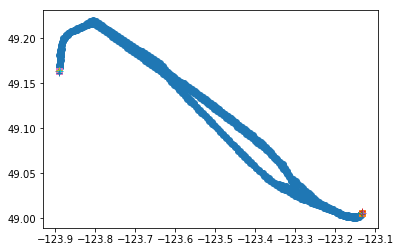

In [23]:
fig, ax = plt.subplots(1, 1)

n_pts = slice(165, 1155)
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

ax.plot(lons[n_pts][on_crossing_mask], lats[n_pts][on_crossing_mask], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

print(lons.time[n_pts][on_crossing_mask][0], lons.time[n_pts][on_crossing_mask][-1])
print('on-crossing minutes: ', lons.time[n_pts][on_crossing_mask].size)
print('in-berth minutes: ', lons.time[n_pts][~on_crossing_mask].size)
total_on_crossing_minutes += lons.time[n_pts][on_crossing_mask].size
total_in_berth_minutes += lons.time[n_pts][~on_crossing_mask].size

The third crossing is southbound again:

<xarray.DataArray 'time' ()>
array(1503863220000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T19:47:00 <xarray.DataArray 'time' ()>
array(1503870000000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T21:40:00
on-crossing minutes:  114
in-berth minutes:  46


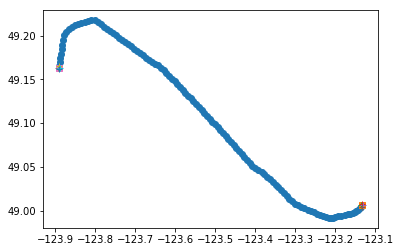

In [24]:
fig, ax = plt.subplots(1, 1)

n_pts = slice(1155, 1315)
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

ax.plot(lons[n_pts][on_crossing_mask], lats[n_pts][on_crossing_mask], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

print(lons.time[n_pts][on_crossing_mask][0], lons.time[n_pts][on_crossing_mask][-1])
print('on-crossing minutes: ', lons.time[n_pts][on_crossing_mask].size)
print('in-berth minutes: ', lons.time[n_pts][~on_crossing_mask].size)
total_on_crossing_minutes += lons.time[n_pts][on_crossing_mask].size
total_in_berth_minutes += lons.time[n_pts][~on_crossing_mask].size

The final northbound crossing is incomplete:

<xarray.DataArray 'time' ()>
array(1503872520000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T22:22:00 <xarray.DataArray 'time' ()>
array(1503878340000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-08-27T23:59:00
on-crossing minutes:  98
in-berth minutes:  27


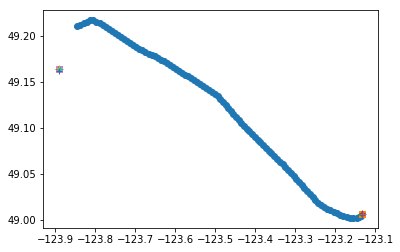

In [25]:
fig, ax = plt.subplots(1, 1)

n_pts = slice(1315, None)
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal, n_pts)

ax.plot(lons[n_pts][on_crossing_mask], lats[n_pts][on_crossing_mask], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')
ax.plot(tsw_data[0] - tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] + tsw_radius, '+')
ax.plot(tsw_data[0] + tsw_radius, tsw_data[1], '+')
ax.plot(tsw_data[0], tsw_data[1] - tsw_radius, '+')

ax.plot(dp_data[0], dp_data[1], 's')
ax.plot(dp_data[0] - dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] + dp_radius, '+')
ax.plot(dp_data[0] + dp_radius, dp_data[1], '+')
ax.plot(dp_data[0], dp_data[1] - dp_radius, '+')

print(lons.time[n_pts][on_crossing_mask][0], lons.time[n_pts][on_crossing_mask][-1])
print('on-crossing minutes: ', lons.time[n_pts][on_crossing_mask].size)
print('in-berth minutes: ', lons.time[n_pts][~on_crossing_mask].size)
total_on_crossing_minutes += lons.time[n_pts][on_crossing_mask].size
total_in_berth_minutes += lons.time[n_pts][~on_crossing_mask].size

In [26]:
print('total on-crossing minutes:', total_on_crossing_minutes)
print('total in-berth minues:', total_in_berth_minutes)

total on-crossing minutes: 895
total in-berth minues: 545


The on-crossing mask for the entire dataset:

In [27]:
on_crossing_mask = on_crossing(lons, lats, dp_terminal, tsw_terminal)
print('total on-crossing minutes:', sum(1 for minute in on_crossing_mask[on_crossing_mask == True]))
print('total in-berth minutes:', sum(1 for minute in on_crossing_mask[on_crossing_mask == False]))

total on-crossing minutes: 895
total in-berth minutes: 545


### Calculate Index Numbers for Each Crossing

Calculate crossing numbers from on-crossing mask.
We have to make crossing numbers floats if we want to use NaNs for times when the ferry is
in-berth because NumPy lacks the concept on an integer NaN.

In [28]:
def calc_crossing_numbers(on_crossing_mask):
    crossing_numbers = np.empty_like(on_crossing_mask, dtype=float)
    crossing_number = 0
    crossing_numbers[0] = 0 if on_crossing_mask[0] else np.nan
    for minute in range(1, crossing_numbers.size):
        if not on_crossing_mask[minute-1] and on_crossing_mask[minute]:
            crossing_number += 1
        if on_crossing_mask[minute]:
            crossing_numbers[minute] = crossing_number
        else:
            crossing_numbers[minute] = np.nan
    return crossing_numbers

crossing_numbers = xr.DataArray(
    name='crossing_number',
    data=calc_crossing_numbers(on_crossing_mask),
    coords={
        'time': lons.time.values,
    },
    dims='time',
)    
print(crossing_numbers)

<xarray.DataArray 'crossing_number' (time: 1440)>
array([ 0.,  0.,  0., ...,  8.,  8.,  8.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...


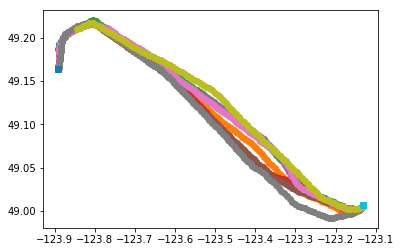

In [29]:
fig, ax = plt.subplots(1, 1)

for crossing in range(int(crossing_numbers.max())+1):
    ax.plot(lons[crossing_numbers == crossing], lats[crossing_numbers == crossing], 'o')

ax.plot(tsw_data[0], tsw_data[1], 's')

ax.plot(dp_data[0], dp_data[1], 's')

## Temperature, Conductivity, and Salinity

Request a day's worth of temperature,
conductivity,
and salinity data,
and parse them into an `xarray.Dataset`:

In [30]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station=f'{onc_station}', 
    deviceCategory='TSG',
    sensors='',  # fails if conductivity is included in sensors list, so '' gets all sensors
    dateFrom=data_tools.onc_datetime(f'{data_date.format("YYYY-MM-DD")} 00:00', 'utc'),
)

tsg_data = data_tools.onc_json_to_dataset(onc_data)

In [31]:
tsg_data

<xarray.Dataset>
Dimensions:       (sampleTime: 86399)
Coordinates:
  * sampleTime    (sampleTime) datetime64[ns] 2017-08-27T00:00:00.837000 ...
Data variables:
    Conductivity  (sampleTime) float64 3.506 3.506 3.505 3.506 3.506 3.506 ...
    salinity      (sampleTime) float64 25.84 25.85 25.85 25.85 25.85 25.85 ...
    temperature   (sampleTime) float64 18.33 18.31 18.3 18.31 18.31 18.32 ...
Attributes:
    dateFrom:            2017-08-27T00:00:00.000Z
    dateTo:              None
    deviceCategory:      TSG
    nextDateFrom:        2017-08-28T00:00:00.876Z
    outputFormat:        None
    rowLimit:            None
    sensors:             None
    station:             TWDP
    totalActualSamples:  259197

### Filter Data Based on `qaqcFlag` Values

Filter the temperature data to exclude samples for which `qaqcFlag != 1`:

In [32]:
tsg_data.temperature

<xarray.DataArray 'temperature' (sampleTime: 86399)>
array([ 18.3294,  18.3123,  18.3043, ...,  19.3351,  19.3313,  19.3278])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.837000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Temperature
    unitOfMeasure:  C
    actualSamples:  86399

In [33]:
temperature_qaqc_mask = tsg_data.temperature.attrs['qaqcFlag'] == 1
temperature = xr.DataArray(
    name='temperature',
    data=tsg_data.temperature[temperature_qaqc_mask].values,
    coords={'time': tsg_data.temperature.sampleTime[temperature_qaqc_mask].values},
    dims=('time',),
)

In [34]:
temperature

<xarray.DataArray 'temperature' (time: 54743)>
array([ 18.3294,  18.3123,  18.3043, ...,  19.3351,  19.3313,  19.3278])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.837000 ...

Filter the conductivity data to exclude samples for which `qaqcFlag != 1`:

In [35]:
tsg_data.Conductivity

<xarray.DataArray 'Conductivity' (sampleTime: 86399)>
array([ 3.50623,  3.50553,  3.50542, ...,  3.52583,  3.52541,  3.52485])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.837000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Conductivity
    unitOfMeasure:  S/m
    actualSamples:  86399

In [36]:
conductivity_qaqc_mask = tsg_data.Conductivity.attrs['qaqcFlag'] == 1
conductivity = xr.DataArray(
    name='conductivity',
    data=tsg_data.Conductivity[conductivity_qaqc_mask].values,
    coords={'time': tsg_data.Conductivity.sampleTime[conductivity_qaqc_mask].values},
    dims=('time',),
)

In [37]:
conductivity

<xarray.DataArray 'conductivity' (time: 54743)>
array([ 3.50623,  3.50553,  3.50542, ...,  3.52583,  3.52541,  3.52485])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.837000 ...

Filter the salinity data to exclude samples for which `qaqcFlag != 1`:

In [38]:
tsg_data.salinity

<xarray.DataArray 'salinity' (sampleTime: 86399)>
array([ 25.844395,  25.849319,  25.853538, ...,  25.382427,  25.381423,
        25.379112])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.837000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Reference Salinity
    unitOfMeasure:  g/kg
    actualSamples:  86399

In [39]:
salinity_qaqc_mask = tsg_data.salinity.attrs['qaqcFlag'] == 1
salinity = xr.DataArray(
    name='salinity',
    data=tsg_data.salinity[salinity_qaqc_mask].values,
    coords={'time': tsg_data.salinity.sampleTime[salinity_qaqc_mask].values},
    dims=('time',),
)

In [40]:
salinity

<xarray.DataArray 'salinity' (time: 54743)>
array([ 25.844395,  25.849319,  25.853538, ...,  25.382427,  25.381423,
        25.379112])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.837000 ...

## Oxygen Percent Saturation and Concentration

Request a day's worth of % O2 saturation
and concentration data,
and parse them into an `xarray.Dataset`:

In [43]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station=f'{onc_station}', 
    deviceCategory='OXYSENSOR',
    sensors='oxygen_saturation,oxygen_corrected',
    dateFrom=data_tools.onc_datetime(f'{data_date.format("YYYY-MM-DD")} 00:00', 'utc'),
)

o2_data = data_tools.onc_json_to_dataset(onc_data)

In [44]:
o2_data

<xarray.Dataset>
Dimensions:            (sampleTime: 86402)
Coordinates:
  * sampleTime         (sampleTime) datetime64[ns] 2017-08-27T00:00:00.964000 ...
Data variables:
    oxygen_corrected   (sampleTime) float64 2.729 2.729 2.729 2.729 2.729 ...
    oxygen_saturation  (sampleTime) float64 55.86 55.87 55.86 55.87 55.87 ...
Attributes:
    dateFrom:            2017-08-27T00:00:00.000Z
    dateTo:              None
    deviceCategory:      OXYSENSOR
    nextDateFrom:        2017-08-28T00:00:00.491Z
    outputFormat:        None
    rowLimit:            None
    sensors:             oxygen_saturation,oxygen_corrected
    station:             TWDP
    totalActualSamples:  172804

### Filter Data Based on `qaqcFlag` Values

Filter the O2 saturation data to exclude samples for which `qaqcFlag != 1`:

In [68]:
o2_data.oxygen_saturation

<xarray.DataArray 'oxygen_saturation' (sampleTime: 86402)>
array([ 55.86,  55.87,  55.86, ...,  59.56,  59.57,  59.56])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.964000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Oxygen Saturation
    unitOfMeasure:  %
    actualSamples:  86402

In [69]:
o2_saturation_qaqc_mask = o2_data.oxygen_saturation.attrs['qaqcFlag'] == 1
o2_saturation = xr.DataArray(
    name='o2_saturation',
    data=o2_data.oxygen_saturation[o2_saturation_qaqc_mask].values,
    coords={'time': o2_data.oxygen_saturation.sampleTime[o2_saturation_qaqc_mask].values},
    dims=('time',),
)

In [70]:
o2_saturation

<xarray.DataArray 'o2_saturation' (time: 54745)>
array([ 55.86,  55.87,  55.86, ...,  59.56,  59.57,  59.56])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.964000 ...

Filter the corrected O2 concentration data to exclude samples for which `qaqcFlag != 1`:

In [71]:
o2_data.oxygen_corrected

<xarray.DataArray 'oxygen_corrected' (sampleTime: 86402)>
array([ 2.729062,  2.729373,  2.728728, ...,  2.924059,  2.924686,  2.924509])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.964000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Oxygen Concentration Corrected
    unitOfMeasure:  ml/l
    actualSamples:  86402

In [72]:
o2_concentration_corrected_qaqc_mask = o2_data.oxygen_corrected.attrs['qaqcFlag'] == 1
o2_concentration_corrected = xr.DataArray(
    name='o2_concentration_corrected',
    data=o2_data.oxygen_corrected[o2_concentration_corrected_qaqc_mask].values,
    coords={'time': o2_data.oxygen_corrected.sampleTime[o2_concentration_corrected_qaqc_mask].values},
    dims=('time',),
)

In [73]:
o2_concentration_corrected

<xarray.DataArray 'o2_concentration_corrected' (time: 54745)>
array([ 2.729062,  2.729373,  2.728728, ...,  2.924059,  2.924686,  2.924509])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.964000 ...

## CDOM Fluorescence, Chlorophyll, and Turbidity

Request a day's worth of CDOM fluorescence, 
chlorophyll, 
and turbidity data,
and parse them into an `xarray.Dataset`:

In [48]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station=f'{onc_station}', 
    deviceCategory='TURBCHLFL',
    sensors='cdom_fluorescence,chlorophyll,turbidity',
    dateFrom=data_tools.onc_datetime(f'{data_date.format("YYYY-MM-DD")} 00:00', 'utc'),
)

turbchlfl_data = data_tools.onc_json_to_dataset(onc_data)

In [49]:
turbchlfl_data

<xarray.Dataset>
Dimensions:            (sampleTime: 80552)
Coordinates:
  * sampleTime         (sampleTime) datetime64[ns] 2017-08-27T00:00:00.894000 ...
Data variables:
    cdom_fluorescence  (sampleTime) float64 4.692 4.876 4.416 4.508 4.876 ...
    chlorophyll        (sampleTime) float64 11.49 11.59 11.61 11.59 11.79 ...
    turbidity          (sampleTime) float64 5.106 4.662 5.254 4.588 4.958 ...
Attributes:
    dateFrom:            2017-08-27T00:00:00.000Z
    dateTo:              None
    deviceCategory:      TURBCHLFL
    nextDateFrom:        2017-08-28T00:00:01.064Z
    outputFormat:        None
    rowLimit:            None
    sensors:             cdom_fluorescence,chlorophyll,turbidity
    station:             TWDP
    totalActualSamples:  241656

### Filter Data Based on `qaqcFlag` Values

Filter the CDOM fluorescence data to exclude samples for which `qaqcFlag != 1`:

In [50]:
turbchlfl_data.cdom_fluorescence

<xarray.DataArray 'cdom_fluorescence' (sampleTime: 80552)>
array([ 4.692,  4.876,  4.416, ...,  4.508,  4.508,  4.6  ])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.894000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     CDOM Fluorescence
    unitOfMeasure:  ppb
    actualSamples:  80552

In [51]:
cdom_fluorescence_qaqc_mask = turbchlfl_data.cdom_fluorescence.attrs['qaqcFlag'] == 1
cdom_fluorescence = xr.DataArray(
    name='cdom_fluorescence',
    data=turbchlfl_data.cdom_fluorescence[cdom_fluorescence_qaqc_mask].values,
    coords={'time': turbchlfl_data.cdom_fluorescence.sampleTime[cdom_fluorescence_qaqc_mask].values},
    dims=('time',),
)

In [52]:
cdom_fluorescence

<xarray.DataArray 'cdom_fluorescence' (time: 51028)>
array([ 4.692,  4.876,  4.416, ...,  4.508,  4.508,  4.6  ])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.894000 ...

Filter the chlorophyll data to exclude samples for which `qaqcFlag != 1`:

In [54]:
turbchlfl_data.chlorophyll

<xarray.DataArray 'chlorophyll' (sampleTime: 80552)>
array([ 11.4924,  11.59  ,  11.6144, ...,   5.429 ,   5.429 ,   5.49  ])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.894000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Chlorophyll
    unitOfMeasure:  ug/l
    actualSamples:  80552

In [55]:
chlorophyll_qaqc_mask = turbchlfl_data.chlorophyll.attrs['qaqcFlag'] == 1
chlorophyll = xr.DataArray(
    name='chlorophyll',
    data=turbchlfl_data.chlorophyll[chlorophyll_qaqc_mask].values,
    coords={'time': turbchlfl_data.chlorophyll.sampleTime[chlorophyll_qaqc_mask].values},
    dims=('time',),
)

In [56]:
chlorophyll

<xarray.DataArray 'chlorophyll' (time: 51028)>
array([ 11.4924,  11.59  ,  11.6144, ...,   5.429 ,   5.429 ,   5.49  ])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.894000 ...

Filter the turbidity data to exclude samples for which `qaqcFlag != 1`:

In [57]:
turbchlfl_data.turbidity

<xarray.DataArray 'turbidity' (sampleTime: 80552)>
array([ 5.106,  4.662,  5.254, ...,  5.476,  5.772,  5.55 ])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.894000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Turbidity
    unitOfMeasure:  NTU
    actualSamples:  80552

In [58]:
turbidity_qaqc_mask = turbchlfl_data.turbidity.attrs['qaqcFlag'] == 1
turbidity = xr.DataArray(
    name='turbidity',
    data=turbchlfl_data.turbidity[turbidity_qaqc_mask].values,
    coords={'time': turbchlfl_data.turbidity.sampleTime[turbidity_qaqc_mask].values},
    dims=('time',),
)

In [59]:
turbidity

<xarray.DataArray 'turbidity' (time: 51028)>
array([ 5.106,  4.662,  5.254, ...,  5.476,  5.772,  5.55 ])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.894000 ...

## CO2 Partial Pressure and Linearized Concentration

Request a day's worth of CO2 partial pressure, 
and linearized concentration data,
and parse them into an `xarray.Dataset`:

In [60]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station=f'{onc_station}', 
    deviceCategory='CO2SENSOR',
    sensors='partial_pressure,co2',
    dateFrom=data_tools.onc_datetime(f'{data_date.format("YYYY-MM-DD")} 00:00', 'utc'),
)

co2_data = data_tools.onc_json_to_dataset(onc_data)

In [61]:
co2_data

<xarray.Dataset>
Dimensions:           (sampleTime: 53916)
Coordinates:
  * sampleTime        (sampleTime) datetime64[ns] 2017-08-27T00:00:00.316000 ...
Data variables:
    co2               (sampleTime) float64 187.5 187.5 187.6 187.7 187.7 ...
    partial_pressure  (sampleTime) float64 199.8 199.9 199.9 200.0 200.1 ...
Attributes:
    dateFrom:            2017-08-27T00:00:00.000Z
    dateTo:              None
    deviceCategory:      CO2SENSOR
    nextDateFrom:        2017-08-28T00:00:01.261Z
    outputFormat:        None
    rowLimit:            None
    sensors:             partial_pressure,co2
    station:             TWDP
    totalActualSamples:  107832

### Filter Data Based on `qaqcFlag` Values

Filter the CO2 partial pressure data to exclude samples for which `qaqcFlag != 1`:

In [62]:
co2_data.partial_pressure

<xarray.DataArray 'partial_pressure' (sampleTime: 53916)>
array([ 199.819985,  199.851962,  199.915914, ...,  195.129435,  195.300133,
        195.40682 ])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.316000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     CO2 Partial Pressure
    unitOfMeasure:  pCO2 uatm
    actualSamples:  53916

In [63]:
co2_partial_pressure_qaqc_mask = co2_data.partial_pressure.attrs['qaqcFlag'] == 1
co2_partial_pressure = xr.DataArray(
    name='co2_partial_pressure',
    data=co2_data.partial_pressure[co2_partial_pressure_qaqc_mask].values,
    coords={'time': co2_data.partial_pressure.sampleTime[co2_partial_pressure_qaqc_mask].values},
    dims=('time',),
)

In [64]:
co2_partial_pressure

<xarray.DataArray 'co2_partial_pressure' (time: 34058)>
array([ 199.819985,  199.851962,  199.915914, ...,  195.129435,  195.300133,
        195.40682 ])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.316000 ...

Filter the linearized CO2 concentration data to exclude samples for which `qaqcFlag != 1`:

In [65]:
co2_data.co2

<xarray.DataArray 'co2' (sampleTime: 53916)>
array([ 187.47,  187.5 ,  187.56, ...,  182.9 ,  183.06,  183.16])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2017-08-27T00:00:00.316000 ...
Attributes:
    qaqcFlag:       [1 1 1 ..., 1 1 1]
    sensorName:     Linearized CO2 Concentration
    unitOfMeasure:  umol/mol
    actualSamples:  53916

In [66]:
co2_concentration_linearized_qaqc_mask = co2_data.co2.attrs['qaqcFlag'] == 1
co2_concentration_linearized = xr.DataArray(
    name='co2_concentration_linearized',
    data=co2_data.co2[co2_concentration_linearized_qaqc_mask].values,
    coords={'time': co2_data.co2.sampleTime[co2_concentration_linearized_qaqc_mask].values},
    dims=('time',),
)

In [67]:
co2_concentration_linearized

<xarray.DataArray 'co2_concentration_linearized' (time: 34068)>
array([ 187.47,  187.5 ,  187.56, ...,  182.9 ,  183.06,  183.16])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27T00:00:00.316000 ...

## Create 1 Minute Resampled Dataset

Station-specific metadata for the dataset:

In [75]:
xr_metadata = {
    f'{onc_station}': {
        'ferry_route_name': ferry_route_name,
        'ONC_stationDescription': onc_station_description,
    },
}

Define an aggregation function to count the samples in each
resampling interval:

In [76]:
def count(values, axis):
    return int(values.size)

Create a dataset of resampled data and their statistics:

In [77]:
now = arrow.now().format('YYYY-MM-DD HH:mm:ss')

ds = xr.Dataset(
    data_vars={
        'longitude': xr.DataArray(
            name='longitude',
            data=lons,
            attrs={
                'ioos_category': 'Location',
                'standard_name': 'longitude',
                'long_name': 'Longitude',
                'units': 'degree_east',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}.N1',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}.N1&deviceCategory=NAV',
            },
        ),
        'latitude': xr.DataArray(
            name='latitude',
            data=lats,
            attrs={
                'ioos_category': 'Location',
                'standard_name': 'latitude',
                'long_name': 'Latitude',
                'units': 'degree_north',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}.N1',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}.N1&deviceCategory=NAV',
            },
        ),
        'on_crossing_mask': xr.DataArray(
            name='on_crossing_mask',
            data=on_crossing_mask,
            attrs={
                'ioos_category': 'identifier',
                'standard_name': 'on_crossing_mask',
                'long_name': 'on crossing',
                'flag_values': '0, 1',
                'flag_meanings': 'in berth, on crossing',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': f'http://dmas.uvic.ca/DataSearch?location={onc_station}',
            },
        ),
        'crossing_number': xr.DataArray(
            name='crossing_number',
            data=crossing_numbers,
            attrs={
                'ioos_category': 'identifier',
                'standard_name': 'crossing_number',
                'long_name': 'crossing number',
                'aggregation_operation': 'mean',
                'flag_values': '0.0, 1.0, 2.0, ...',
                'flag_meanings': 'UTC day crossing number',
                'comment':
                    'The first and last crossings of a UTC day are typically incomplete '
                    'because the ferry operates in the Pacific time zone. '
                    'To obtain a complete dataset for the 1st crossing of the UTC day, '
                    'concatenate the crossing_number==0 observations to the crossing_number==n '
                    'observation from the previous day, where n is max(crossing_number). '
                    'The number of crossings per day varies throughout the year.',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': f'http://dmas.uvic.ca/DataSearch?location={onc_station}',
            },
        ),
        'temperature': xr.DataArray(
            name='temperature',
            data=temperature.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Temperature',
                'standard_name': 'sea_water_temperature',
                'long_name': 'temperature',
                'units': 'degrees_Celcius',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'temperature_std_dev': xr.DataArray(
            name='temperature_std_dev',
            data=temperature.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Temperature',
                'standard_name': 'sea_water_temperature_standard_deviation',
                'long_name': 'temperature standard deviation',
                'units': 'degrees_Celcius',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'temperature_sample_count': xr.DataArray(
            name='temperature_sample_count',
            data=temperature.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Temperature',
                'standard_name': 'sea_water_temperature_sample_count',
                'long_name': 'temperature sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'conductivity': xr.DataArray(
            name='conductivity',
            data=conductivity.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_electrical_conductivity',
                'long_name': 'electrical conductivity',
                'units': 'S/m',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'conductivity_std_dev': xr.DataArray(
            name='conductivity_std_dev',
            data=salinity.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_electrical_conductivity_standard_deviation',
                'long_name': 'electrical conductivity standard deviation',
                'units': 'S/m',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'conductivity_sample_count': xr.DataArray(
            name='conductivity_sample_count',
            data=salinity.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_electrical_conductivity_sample_count',
                'long_name': 'electrical conductivity sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'salinity': xr.DataArray(
            name='salinity',
            data=salinity.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_reference_salinity',
                'long_name': 'reference salinity',
                'units': 'g/kg',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'salinity_std_dev': xr.DataArray(
            name='salinity_std_dev',
            data=salinity.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_reference_salinity_standard_deviation',
                'long_name': 'reference salinity standard deviation',
                'units': 'g/kg',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'salinity_sample_count': xr.DataArray(
            name='salinity_sample_count',
            data=salinity.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_reference_salinity_sample_count',
                'long_name': 'reference salinity sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_saturation': xr.DataArray(
            name='o2_saturation',
            data=o2_saturation.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'fractional_saturation_of_oxygen_in_sea_water',
                'long_name': 'O2 saturation',
                'units': '%',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_saturation_std_dev': xr.DataArray(
            name='o2_saturation_std_dev',
            data=o2_saturation.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'fractional_saturation_of_oxygen_in_sea_water_standard_deviation',
                'long_name': 'O2 saturation standard deviation',
                'units': '%',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_saturation_sample_count': xr.DataArray(
            name='o2_saturation_sample_count',
            data=o2_saturation.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'fractional_saturation_of_oxygen_in_sea_water_sample_count',
                'long_name': 'O2 saturation sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_concentration_corrected': xr.DataArray(
            name='o2_concentration_corrected',
            data=o2_concentration_corrected.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'volume_fraction_of_oxygen_in_sea_water',
                'long_name': 'corrected O2 concentration',
                'units': '%',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_concentration_corrected_std_dev': xr.DataArray(
            name='o2_concentration_corrected_std_dev',
            data=o2_concentration_corrected.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'volume_fraction_of_oxygen_in_sea_water_standard_deviation',
                'long_name': 'corrected O2 concentration standard deviation',
                'units': '%',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'o2_concentration_corrected_sample_count': xr.DataArray(
            name='o2_concentration_corrected_sample_count',
            data=o2_concentration_corrected.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'dissolved_o2',
                'standard_name': 'volume_fraction_of_oxygen_in_sea_water_sample_count',
                'long_name': 'corrected O2 concentration sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TSG',
            },
        ),
        'cdom_fluorescence': xr.DataArray(
            name='cdom_fluorescence',
            data=cdom_fluorescence.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_fraction_of_cdom_fluorescence_in_sea_water',
                'long_name': 'CDOM fluorescence mass fraction',
                'units': 'ppb',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'cdom_fluorescence_std_dev': xr.DataArray(
            name='cdom_fluorescence_std_dev',
            data=cdom_fluorescence.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_fraction_of_cdom_fluorescence_in_sea_water_standard_deviation',
                'long_name': 'CDOM fluorescence standard deviation',
                'units': 'ppb',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'cdom_fluorescence_sample_count': xr.DataArray(
            name='cdom_fluorescence_sample_count',
            data=cdom_fluorescence.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_fraction_of_cdom_fluorescence_in_sea_water_sample_count',
                'long_name': 'CDOM fluorescence sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'chlorophyll': xr.DataArray(
            name='chlorophyll',
            data=chlorophyll.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_concentration_of_chlorophyl_in_sea_water',
                'long_name': 'chlorophyll concentration',
                'units': 'ug/l',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'chlorophyll_std_dev': xr.DataArray(
            name='chlorophyll_std_dev',
            data=chlorophyll.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_concentration_of_chlorophyl_in_sea_water_standard_deviation',
                'long_name': 'chlorophyll concentration standard deviation',
                'units': 'ug/l',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'chlorophyll_sample_count': xr.DataArray(
            name='chlorophyll_sample_count',
            data=chlorophyll.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'mass_concentration_of_chlorophyl_in_sea_water_sample_count',
                'long_name': 'chlorophyll concentration sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'turbidity': xr.DataArray(
            name='turbidity',
            data=turbidity.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'sea_water_turbidity',
                'long_name': 'turbidity',
                'units': 'NTU',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'turbidity_std_dev': xr.DataArray(
            name='turbidity_std_dev',
            data=turbidity.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'sea_water_turbidity_standard_deviation',
                'long_name': 'turbidity standard deviation',
                'units': 'NTU',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'turbidity_sample_count': xr.DataArray(
            name='turbidity_sample_count',
            data=turbidity.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'Optical Properties',
                'standard_name': 'sea_water_turbidity_sample_count',
                'long_name': 'turbidity sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_partial_pressure': xr.DataArray(
            name='co2_partial_pressure',
            data=co2_partial_pressure.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'surface_partial_pressure_of_carbon_dioxide_in_sea_water',
                'long_name': 'CO2 partial pressure',
                'units': 'pCO2 uatm',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_partial_pressure_std_dev': xr.DataArray(
            name='co2_partial_pressure_std_dev',
            data=co2_partial_pressure.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'surface_partial_pressure_of_carbon_dioxide_in_sea_water_standard_deviation',
                'long_name': 'CO2 partial pressure standard deviation',
                'units': 'pCO2 uatm',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_partial_pressure_sample_count': xr.DataArray(
            name='co2_partial_pressure_sample_count',
            data=co2_partial_pressure.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'surface_partial_pressure_of_carbon_dioxide_in_sea_water_sample_count',
                'long_name': 'CO2 partial pressure sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_concentration_linearized': xr.DataArray(
            name='co2_concentration_linearized',
            data=co2_concentration_linearized.resample('1Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'mole_fraction_of_carbon_dioxide_in_sea_water',
                'long_name': 'linearized CO2 concentration',
                'units': 'umol/mol',
                'aggregation_operation': 'mean',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_concentration_linearized_std_dev': xr.DataArray(
            name='co2_concentration_linearized_std_dev',
            data=co2_concentration_linearized.resample('1Min', 'time', how='std'),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'mole_fraction_of_carbon_dioxide_in_sea_water_standard_deviation',
                'long_name': 'linearized CO2 concentration standard deviation',
                'units': 'umol/mol',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url':
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
        'co2_concentration_linearized_sample_count': xr.DataArray(
            name='co2_concentration_linearized_sample_count',
            data=co2_concentration_linearized.resample('1Min', 'time', how=count),
            attrs={
                'ioos_category': 'CO2',
                'standard_name': 'mole_fraction_of_carbon_dioxide_in_sea_water_sample_count',
                'long_name': 'linearized CO2 concentration sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 60,
                'aggregation_interval_units': 'seconds',
                'ONC_stationCode': f'{onc_station}',
                'ONC_data_product_url': 
                    f'http://dmas.uvic.ca/DataSearch?location={onc_station}&deviceCategory=TURBCHLFL',
            },
        ),
    },
    coords={
        'time': lons.time.values,
    },
    attrs={
        'history': f"""{now} Download raw data from ONC scalardata API.
{now} Filter to exclude data with qaqcFlag != 1.
{now} Resample data to 1 minute intervals using mean, standard deviation and count as aggregation functions.
{now} Store as netCDF4 file.
""",
        'ferry_route_name': ferry_route_name,
        'ONC_stationDescription': onc_station_description,
    },
)

If any of the `DataArray`s are short compared to the others the missing values
are filled with `NaN`s.
That makes sense for temperature and salinity values,
and their standard deviations,
but not their sample counts.
So, we change `NaN`s to zeros in the sample count `DataArray`s:

In [78]:
sample_count_vars = [var for var in ds.variables if var.endswith('sample_count')]
for var in sample_count_vars:
    ds[var].values = np.nan_to_num(ds[var].values)

In [79]:
ds

<xarray.Dataset>
Dimensions:                                    (time: 1440)
Coordinates:
  * time                                       (time) datetime64[ns] 2017-08-27 ...
Data variables:
    longitude                                  (time) float64 -123.9 -123.9 ...
    latitude                                   (time) float64 49.2 49.2 ...
    on_crossing_mask                           (time) bool True True True ...
    crossing_number                            (time) float64 0.0 0.0 0.0 ...
    temperature                                (time) float64 18.44 18.83 ...
    temperature_std_dev                        (time) float64 0.1248 0.06376 ...
    temperature_sample_count                   (time) float64 60.0 60.0 60.0 ...
    conductivity                               (time) float64 3.51 3.528 ...
    conductivity_std_dev                       (time) float64 0.03345 ...
    conductivity_sample_count                  (time) float64 60.0 60.0 60.0 ...
    salinity              

## Examine the Dataset

### Temperature

<xarray.DataArray 'temperature_sample_count' (time: 1440)>
array([ 60.,  60.,  60., ...,  60.,  60.,  60.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Temperature
    standard_name:               sea_water_temperature_sample_count
    long_name:                   temperature sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


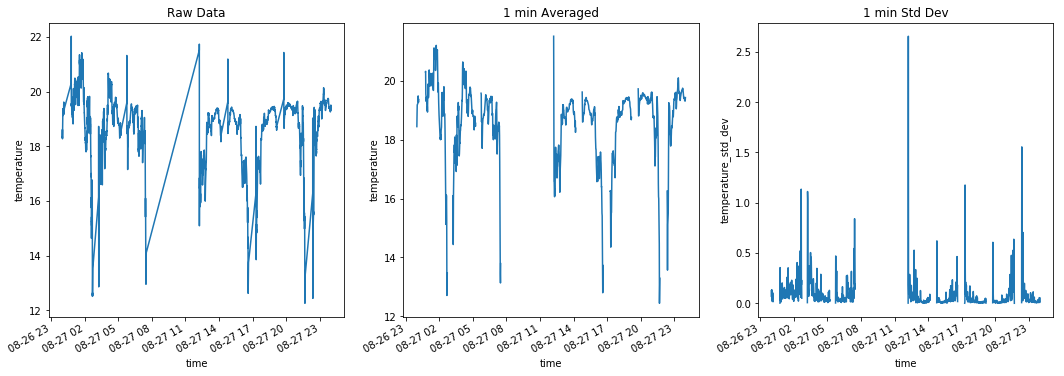

In [80]:
print(ds.temperature_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
temperature.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.temperature.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.temperature_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

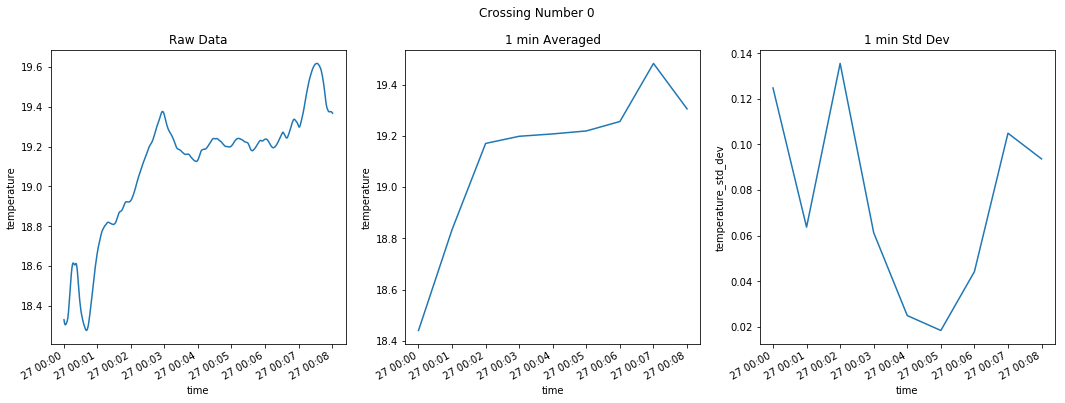

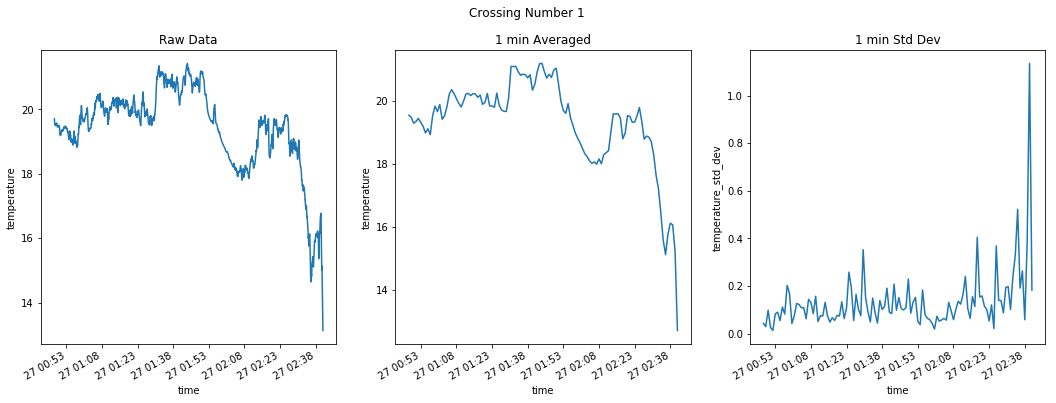

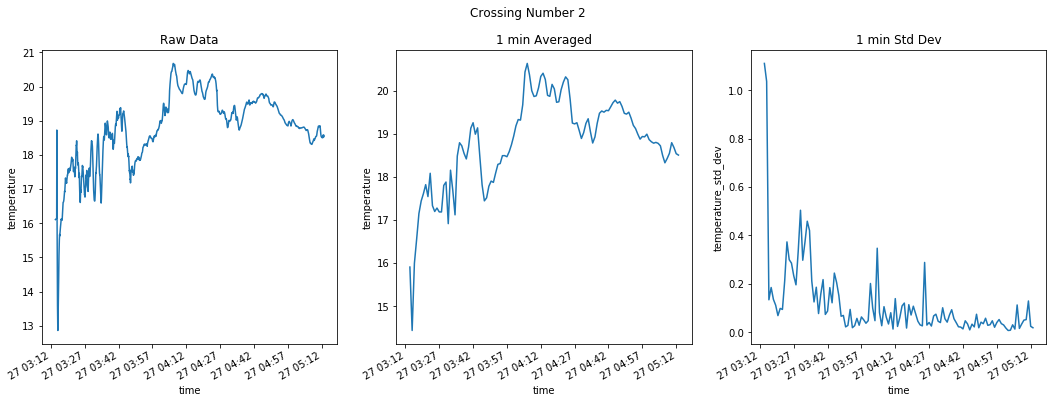

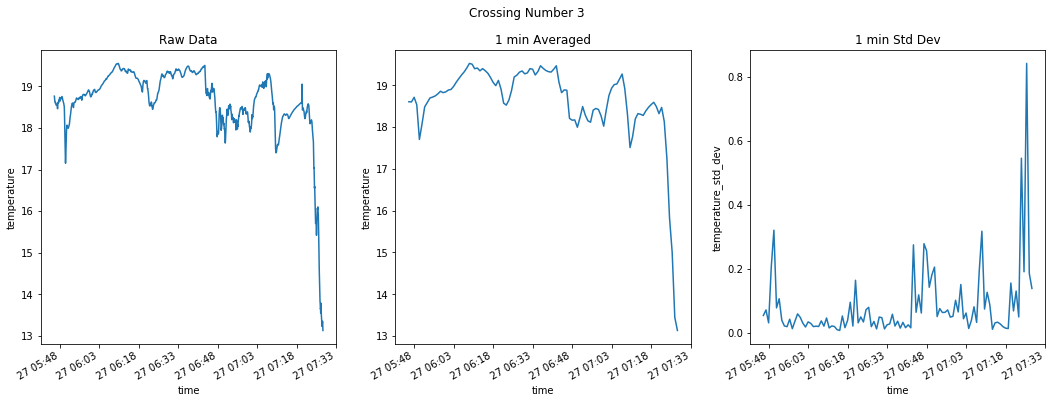

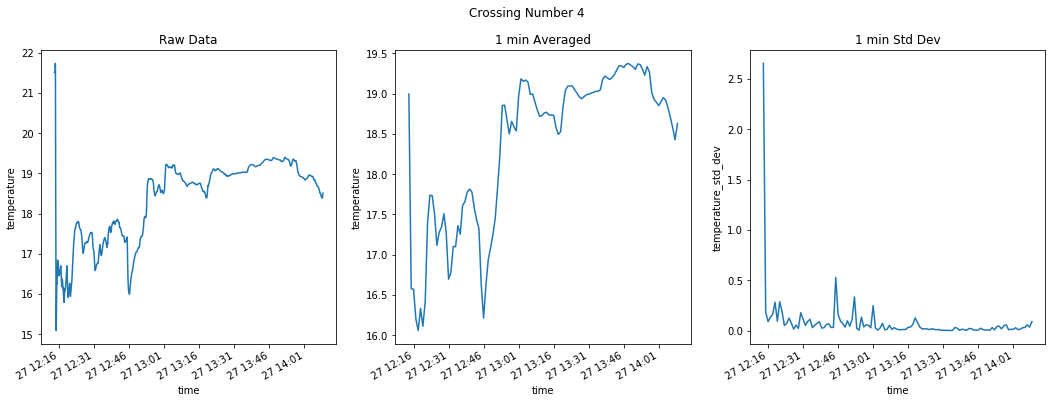

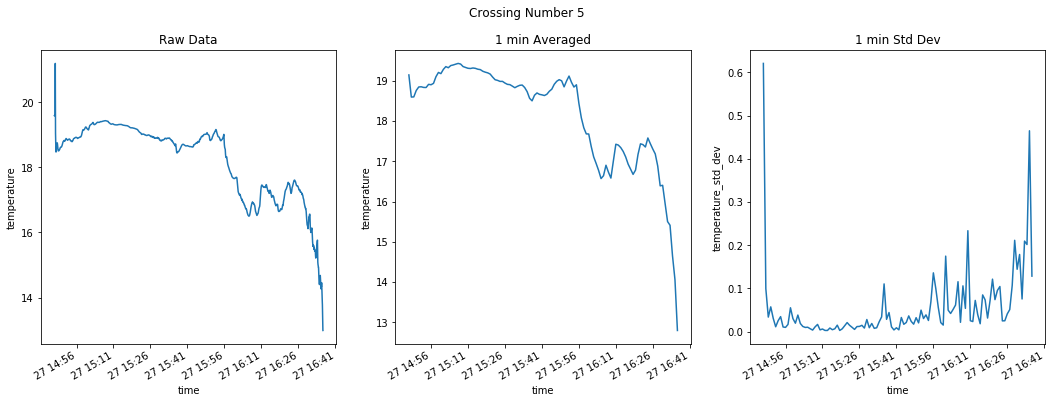

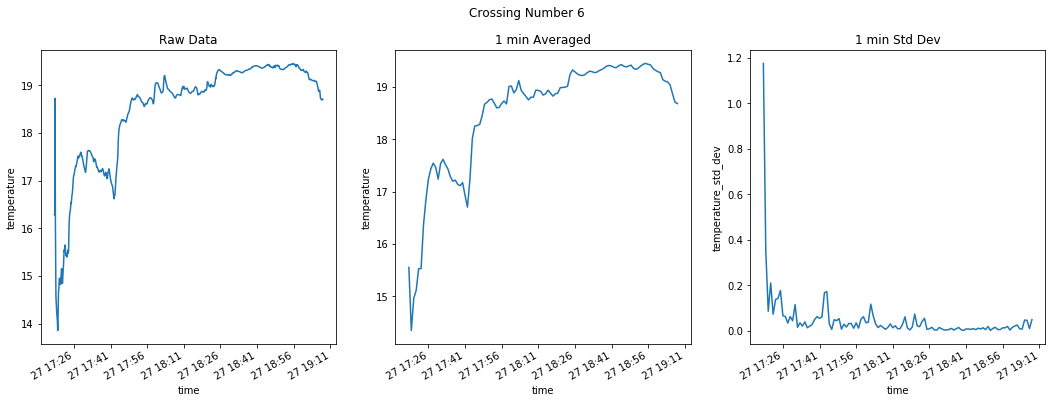

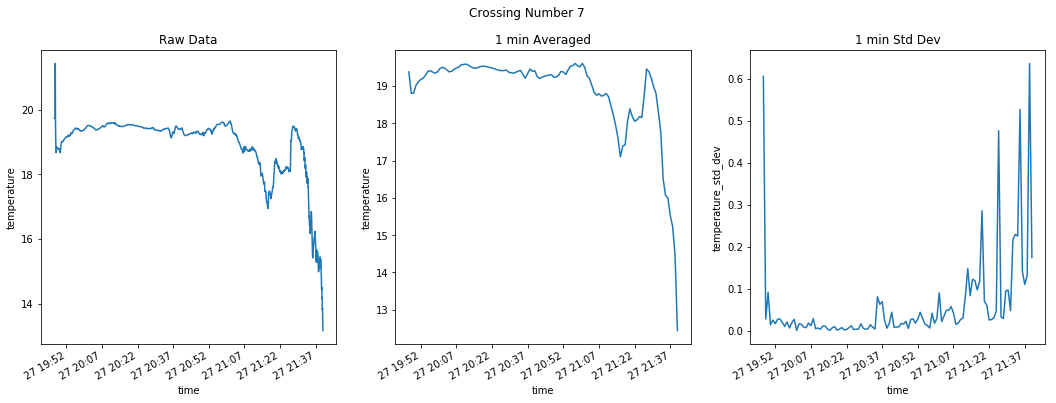

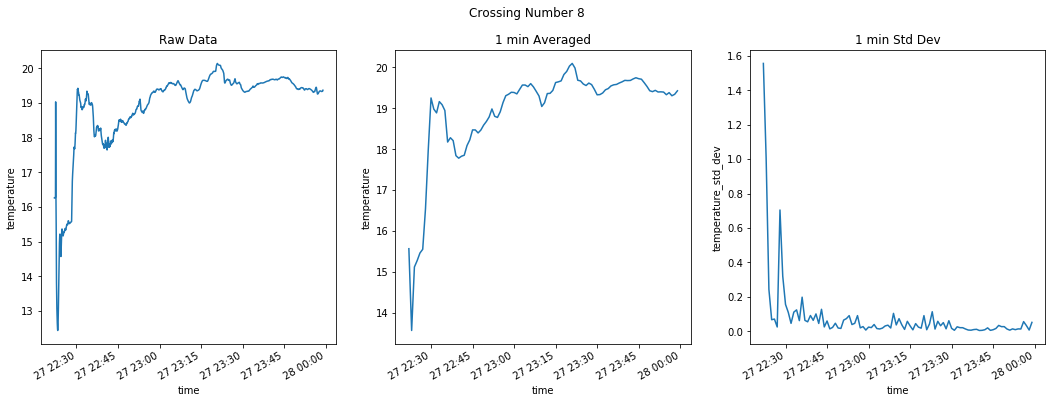

In [81]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    temperature.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.temperature[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.temperature_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Conductivity

<xarray.DataArray 'conductivity_sample_count' (time: 1440)>
array([ 60.,  60.,  60., ...,  60.,  60.,  60.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Salinity
    standard_name:               sea_water_electrical_conductivity_sample_count
    long_name:                   electrical conductivity sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


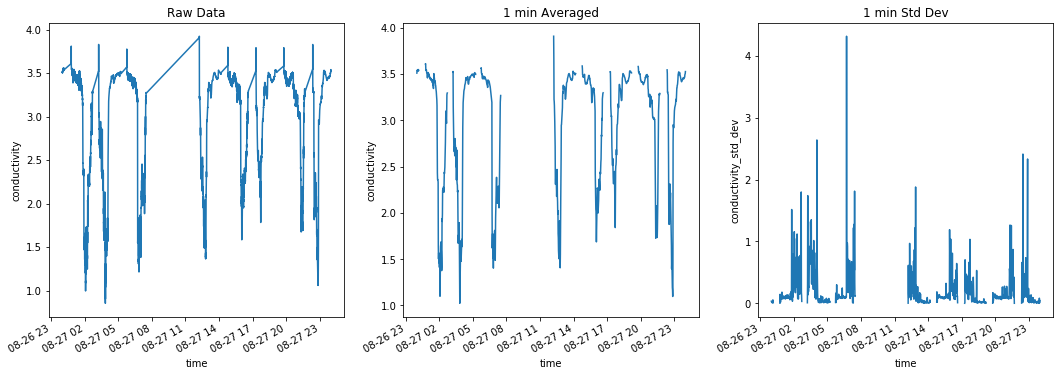

In [82]:
print(ds.conductivity_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
conductivity.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.conductivity.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.conductivity_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

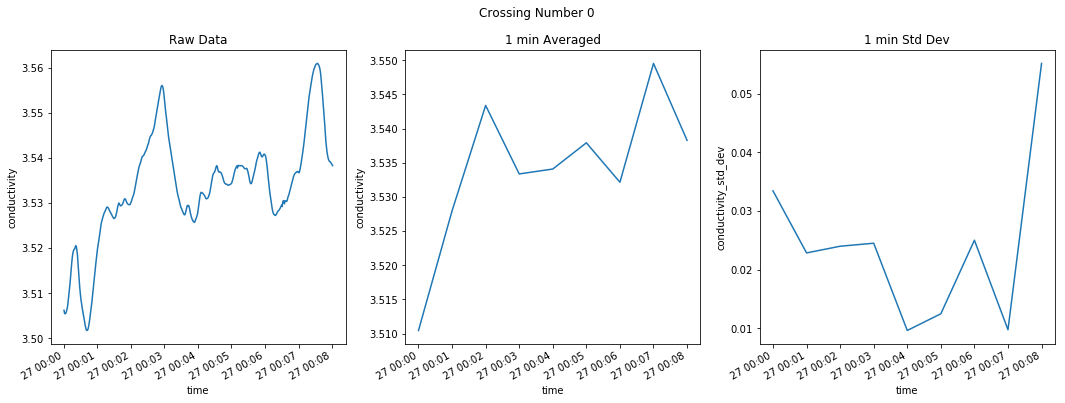

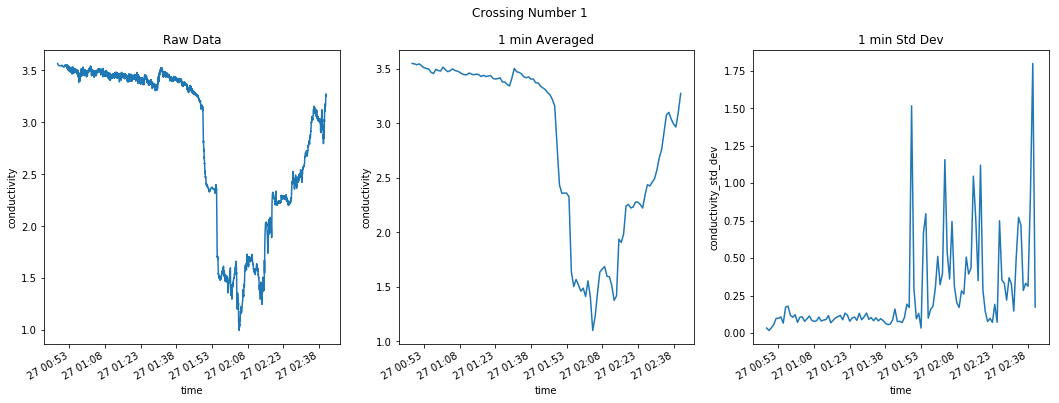

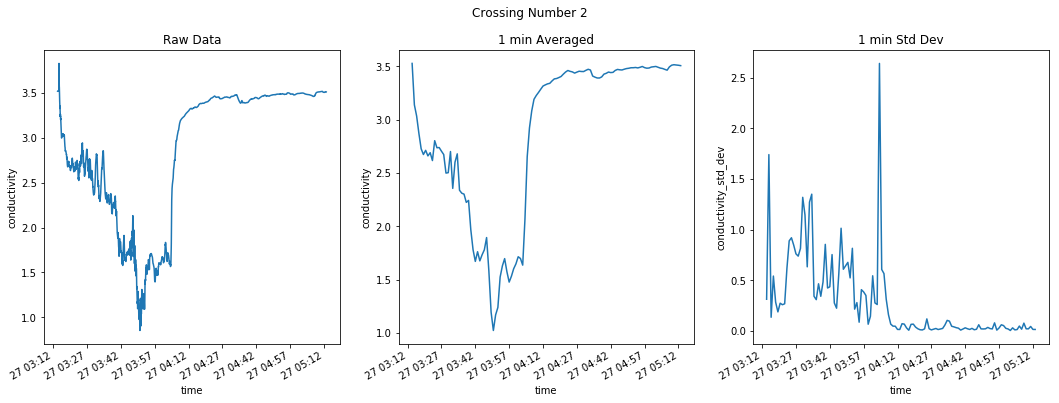

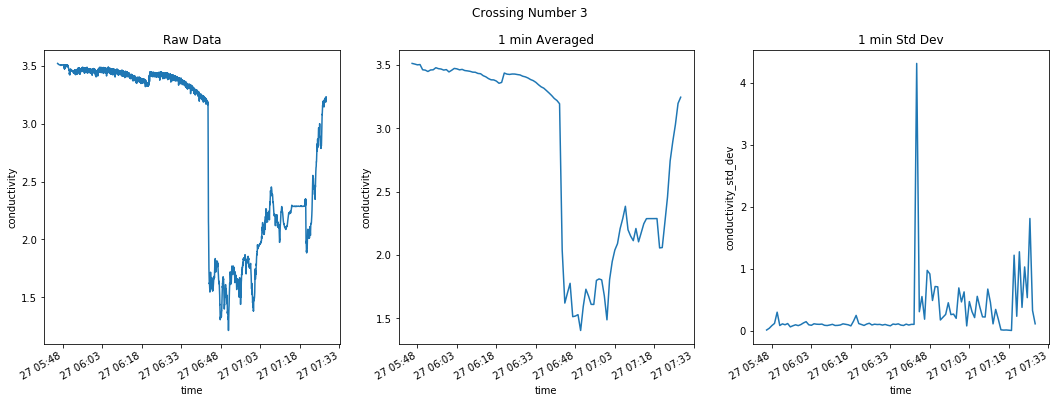

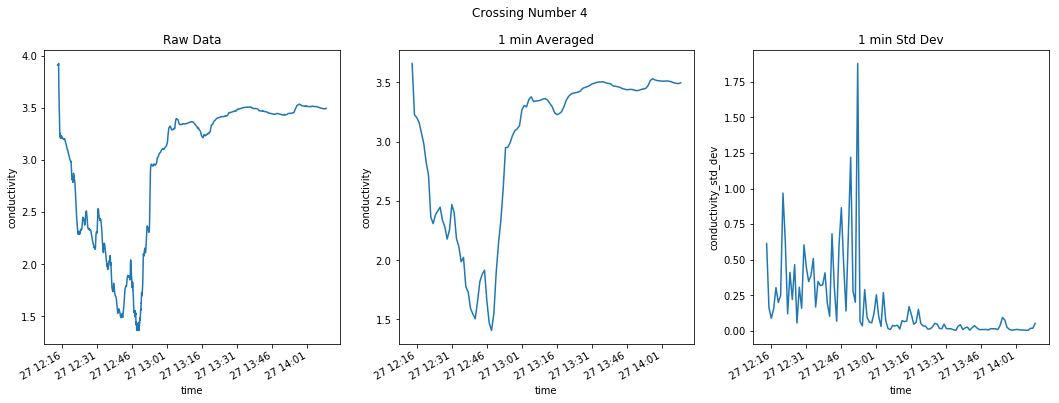

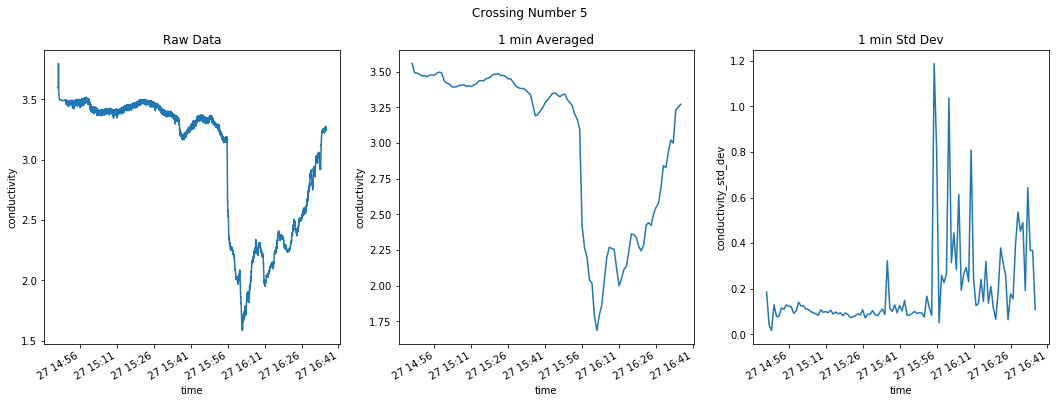

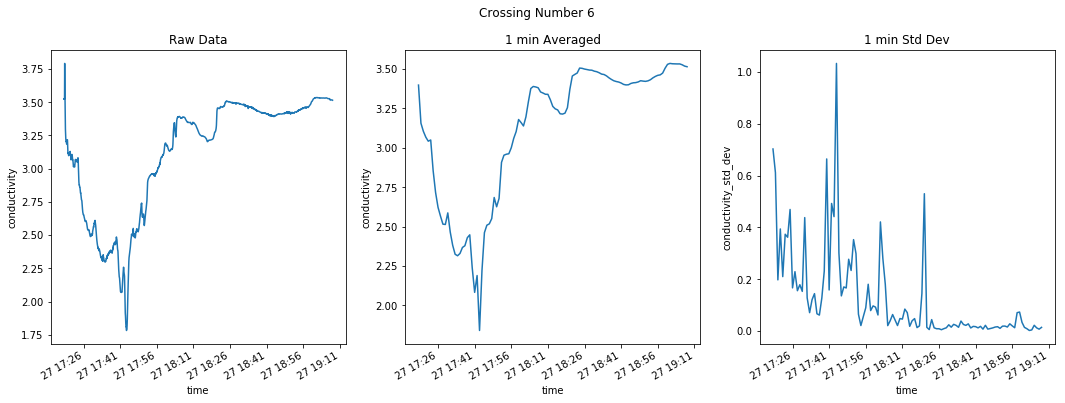

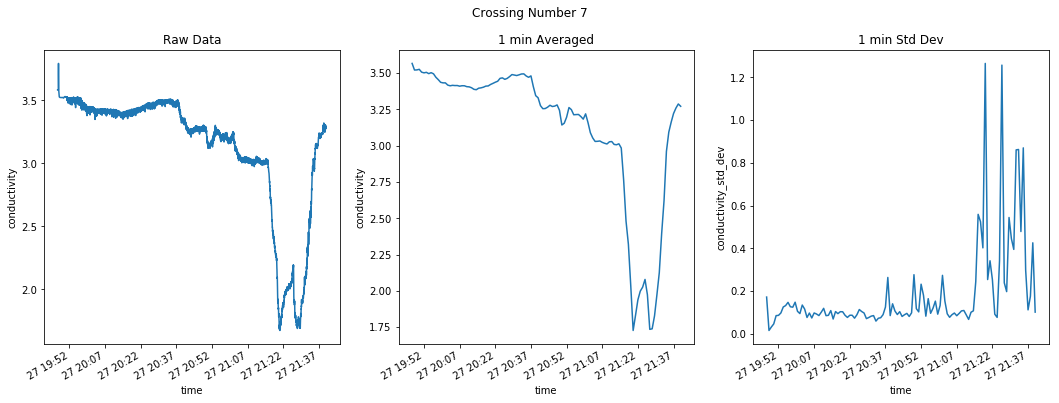

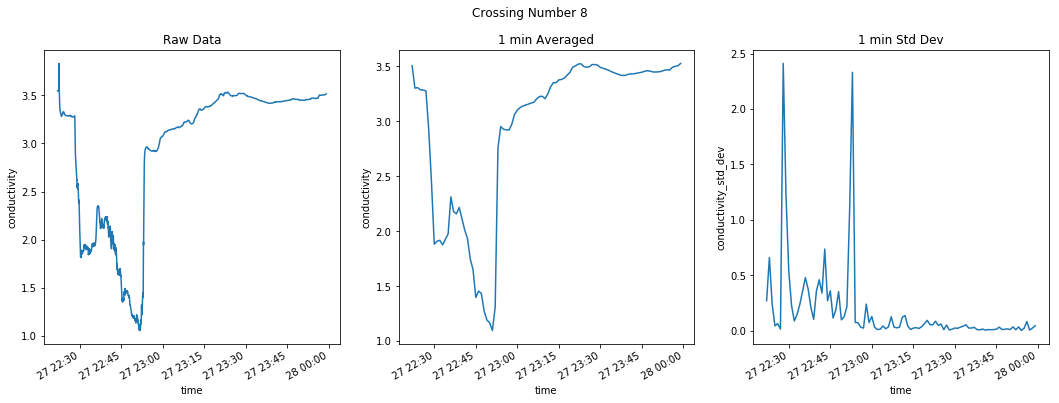

In [83]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    conductivity.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.conductivity[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.conductivity_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Salinity

<xarray.DataArray 'salinity_sample_count' (time: 1440)>
array([ 60.,  60.,  60., ...,  60.,  60.,  60.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Salinity
    standard_name:               sea_water_reference_salinity_sample_count
    long_name:                   reference salinity sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


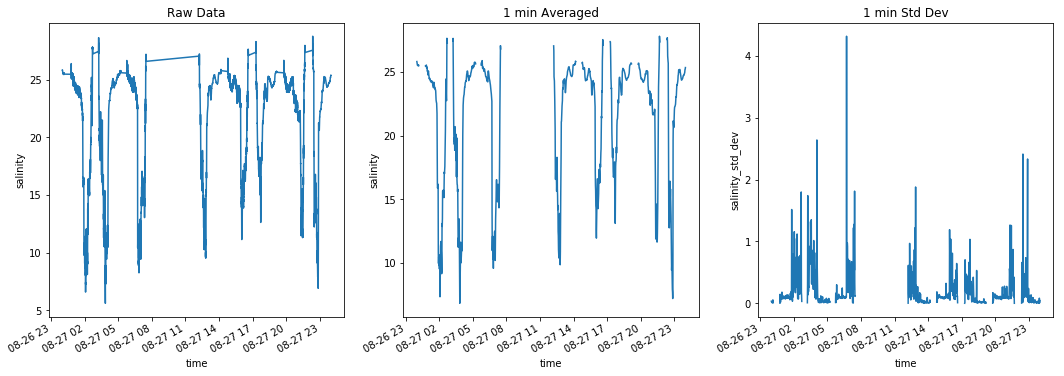

In [84]:
print(ds.salinity_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
salinity.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.salinity.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.salinity_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

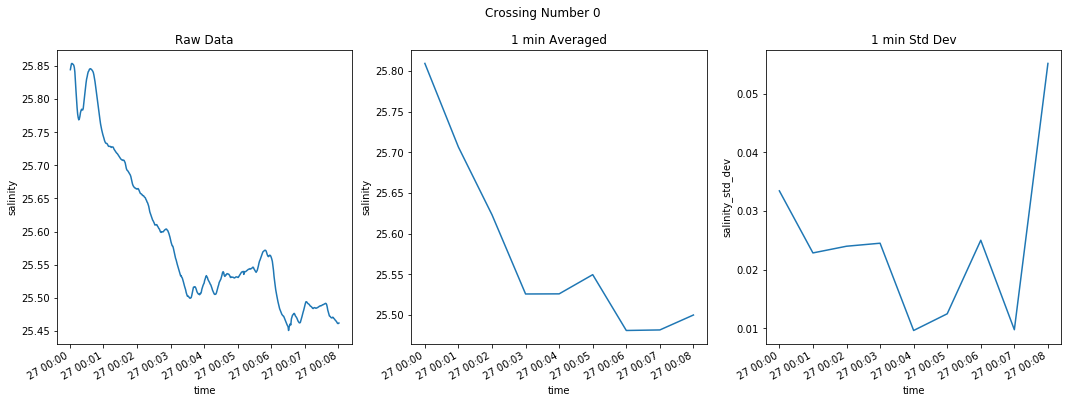

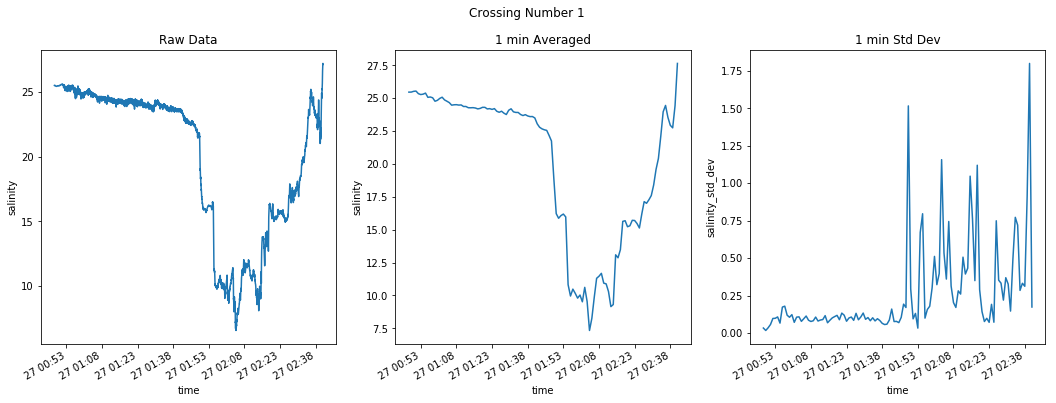

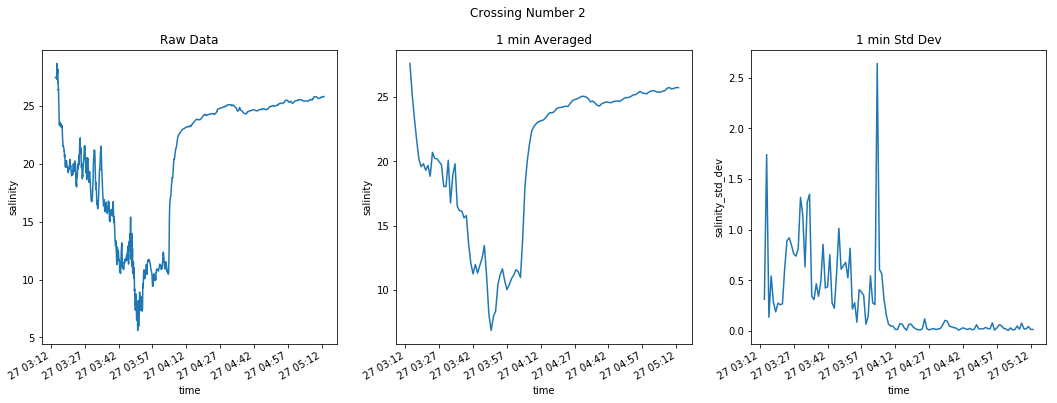

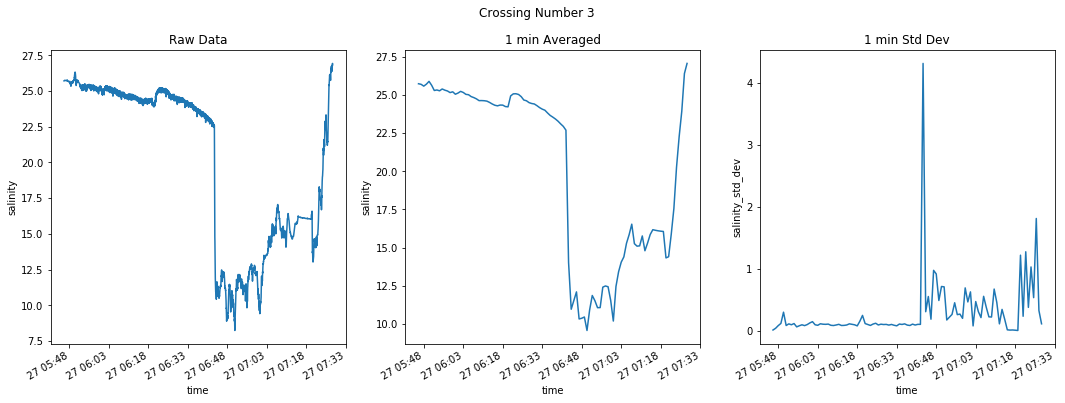

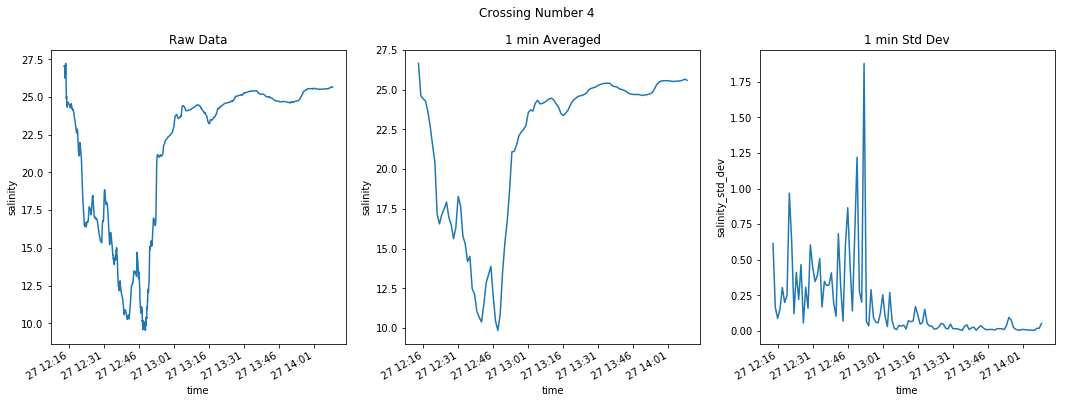

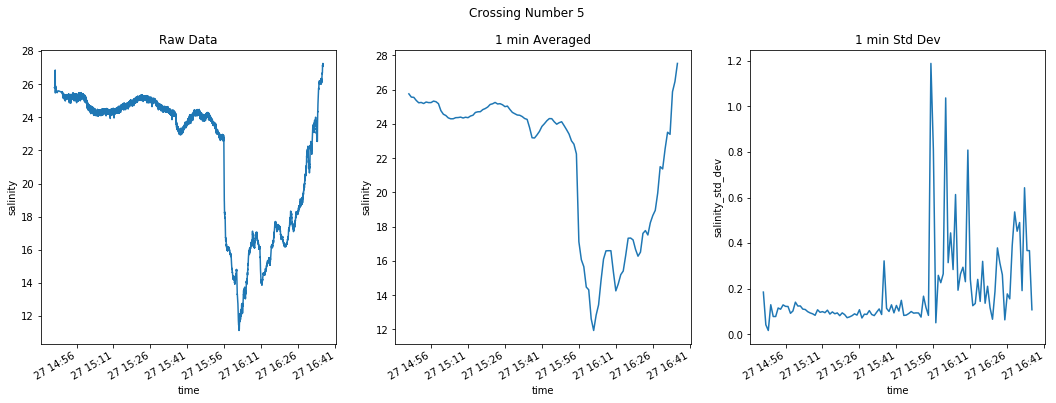

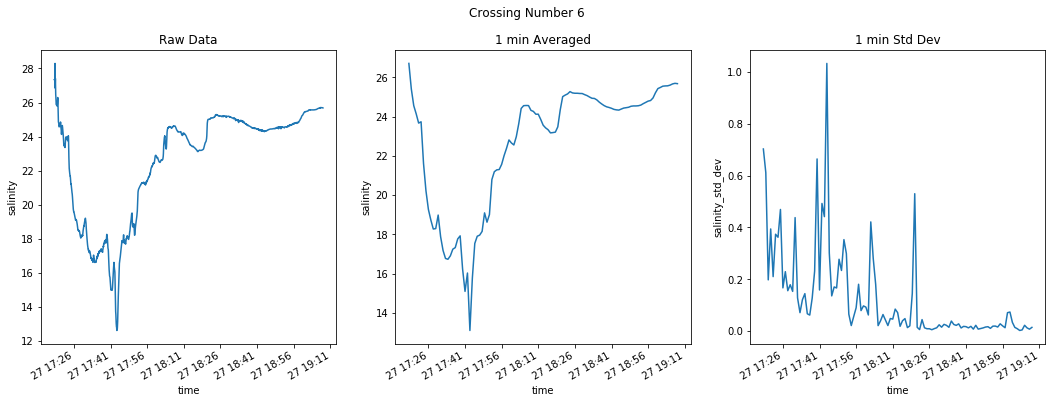

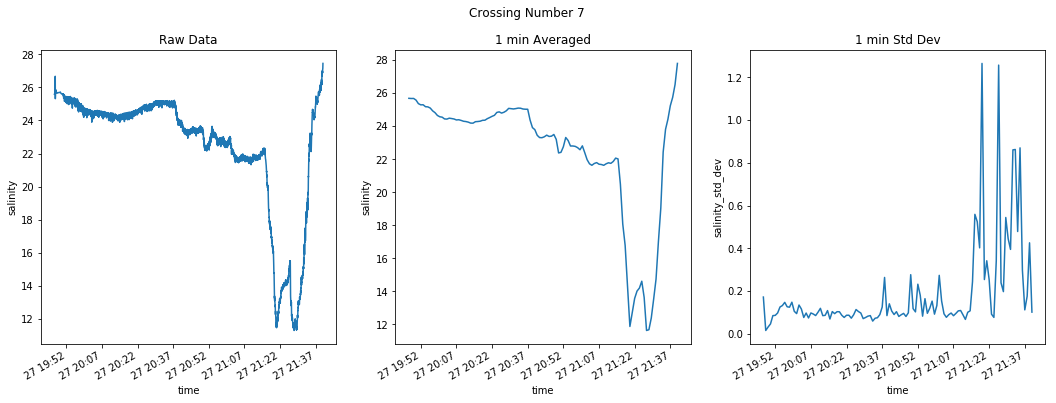

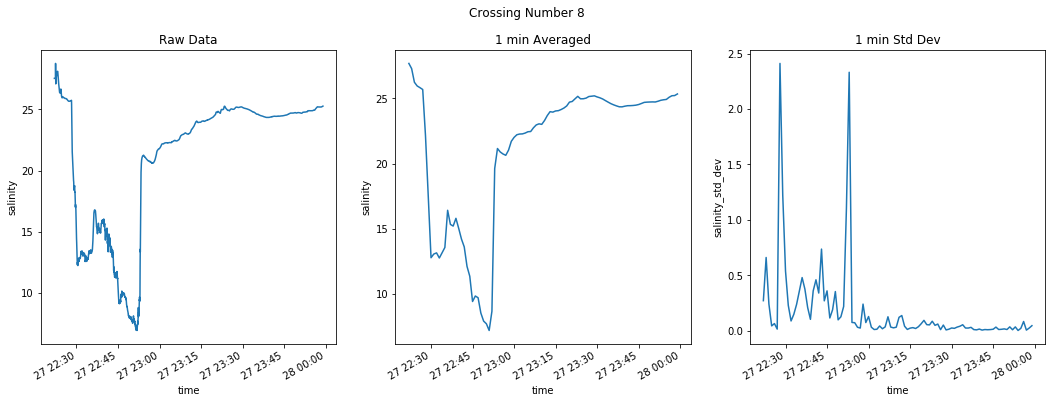

In [86]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    salinity.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.salinity[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.salinity_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### O2 Saturation

<xarray.DataArray 'o2_saturation_sample_count' (time: 1440)>
array([ 60.,  60.,  60., ...,  60.,  60.,  60.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               dissolved_o2
    standard_name:               fractional_saturation_of_oxygen_in_sea_water...
    long_name:                   O2 saturation sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


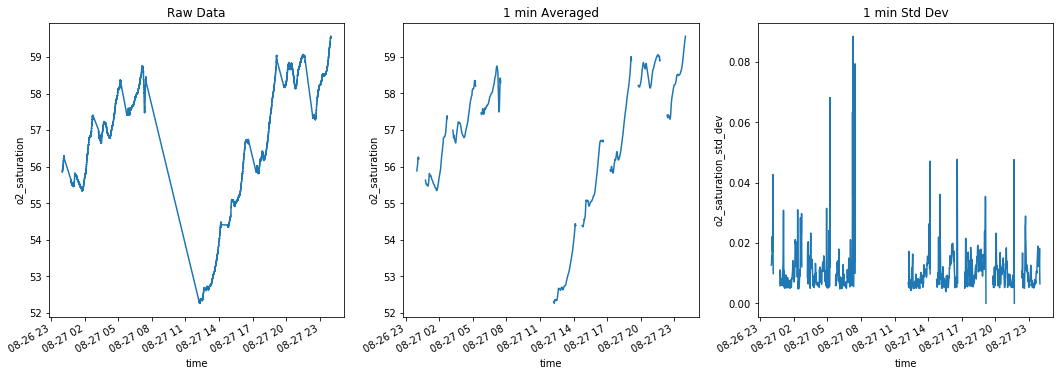

In [98]:
print(ds.o2_saturation_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
o2_saturation.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.o2_saturation.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.o2_saturation_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

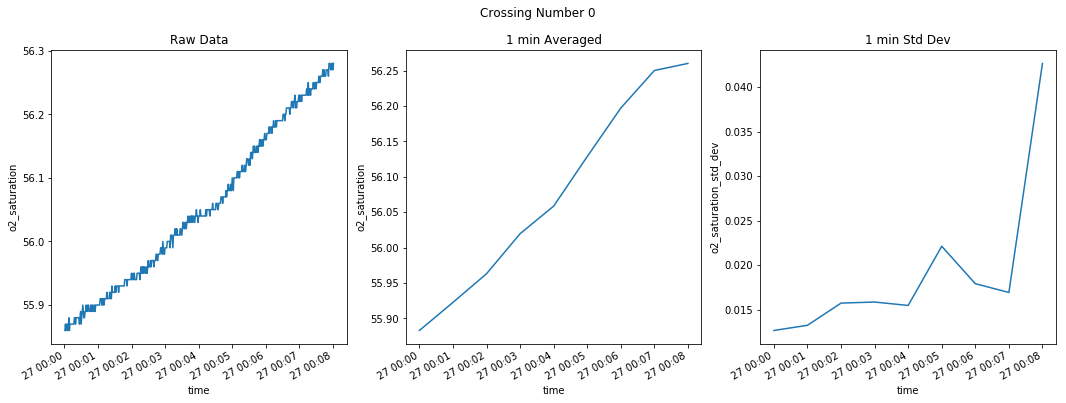

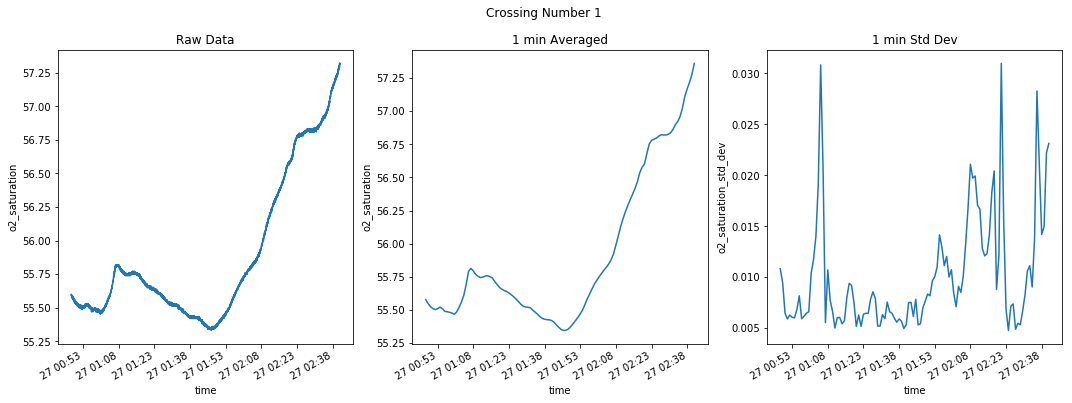

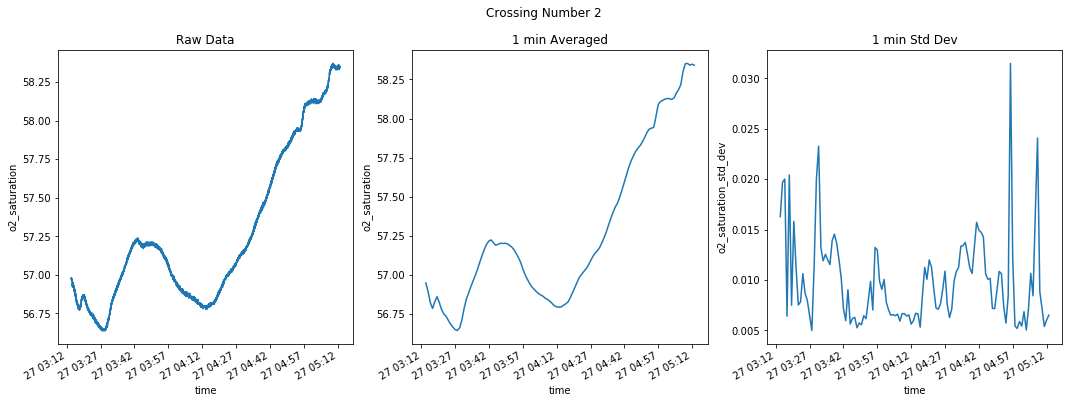

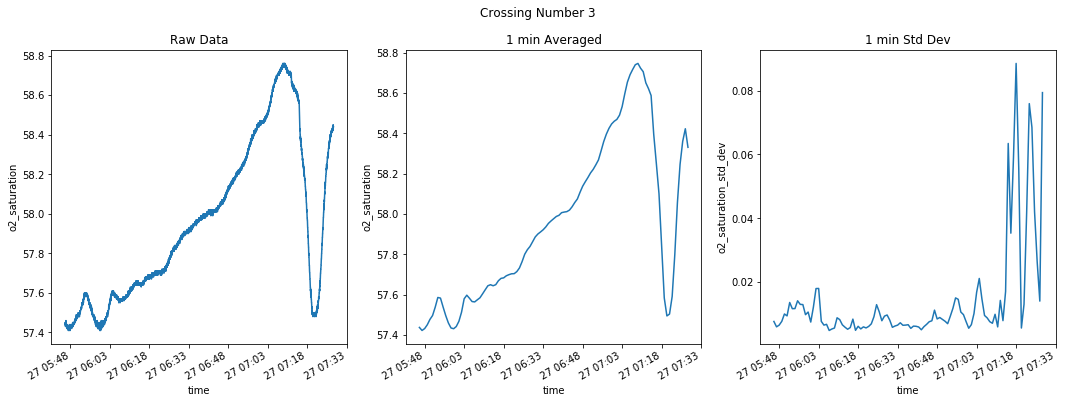

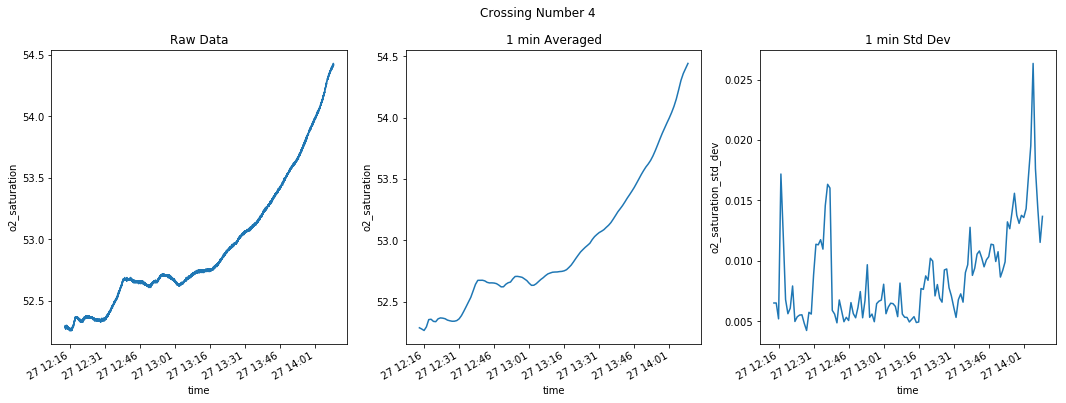

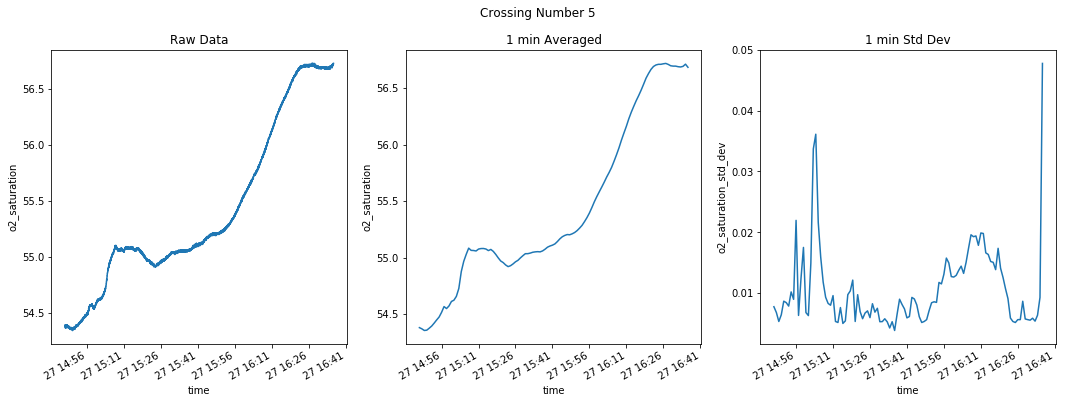

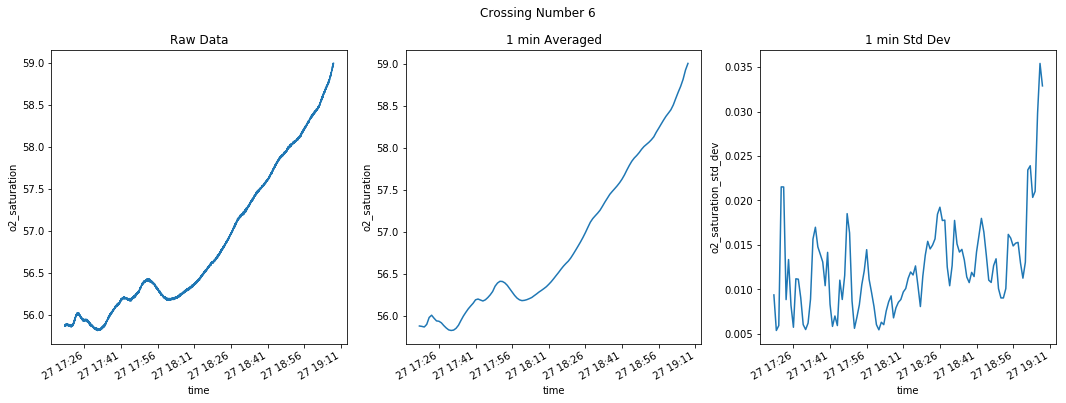

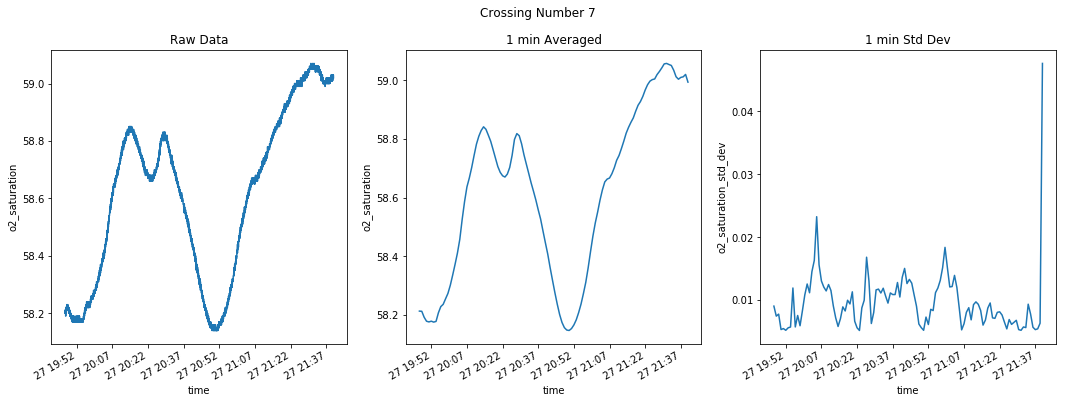

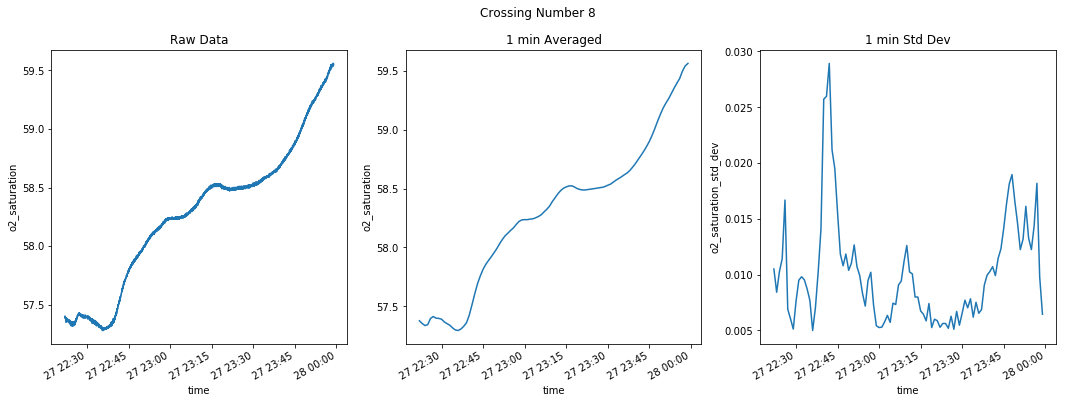

In [99]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    o2_saturation.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.o2_saturation[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.o2_saturation_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Corrected O2 Concentration

<xarray.DataArray 'o2_concentration_corrected_sample_count' (time: 1440)>
array([ 60.,  60.,  60., ...,  60.,  60.,  60.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               dissolved_o2
    standard_name:               volume_fraction_of_oxygen_in_sea_water_sampl...
    long_name:                   corrected O2 concentration sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


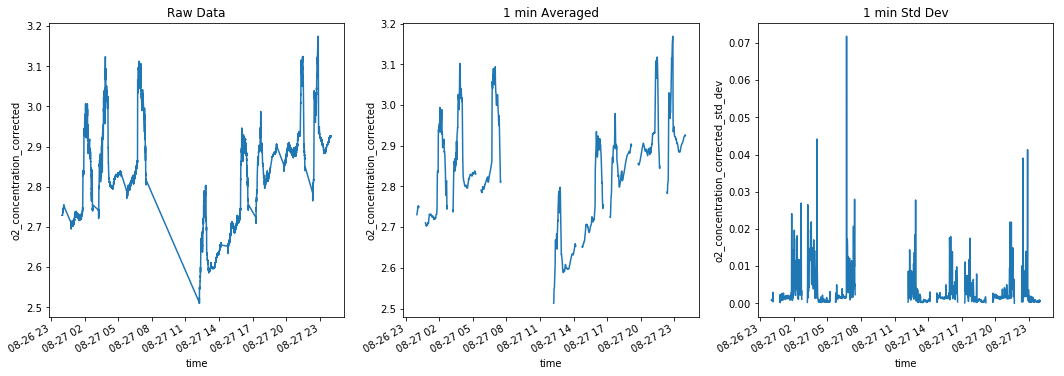

In [100]:
print(ds.o2_concentration_corrected_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
o2_concentration_corrected.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.o2_concentration_corrected.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.o2_concentration_corrected_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

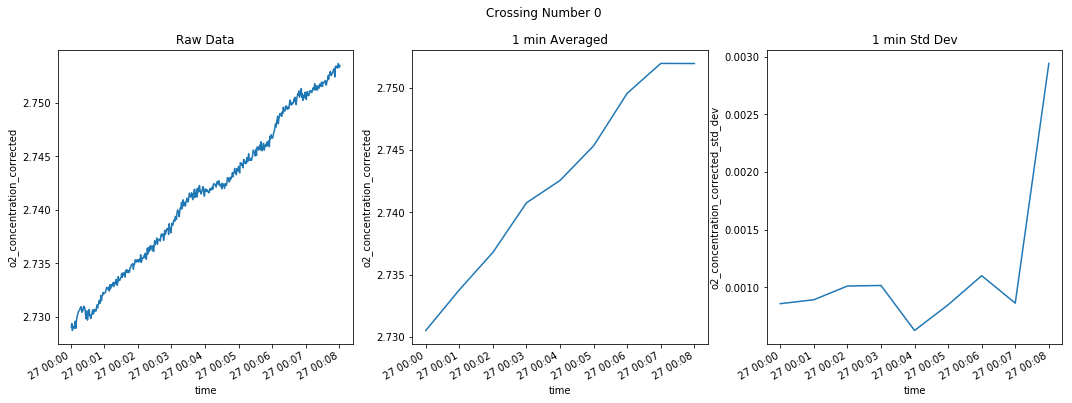

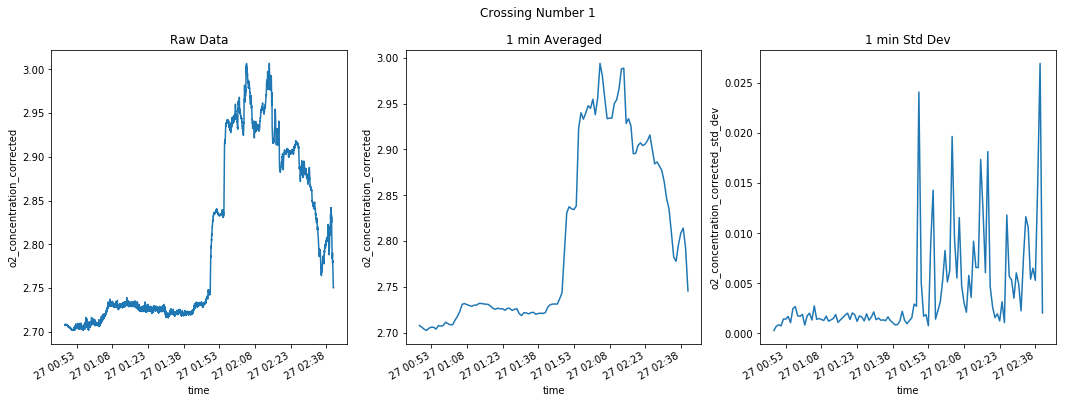

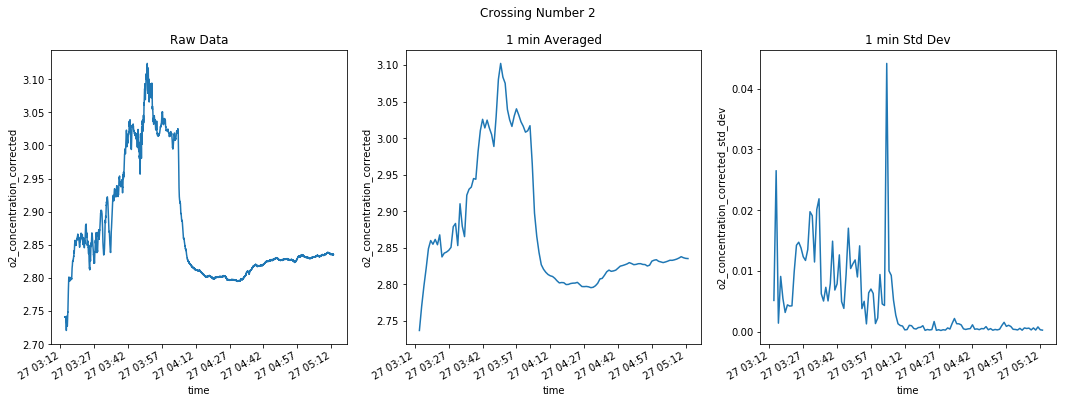

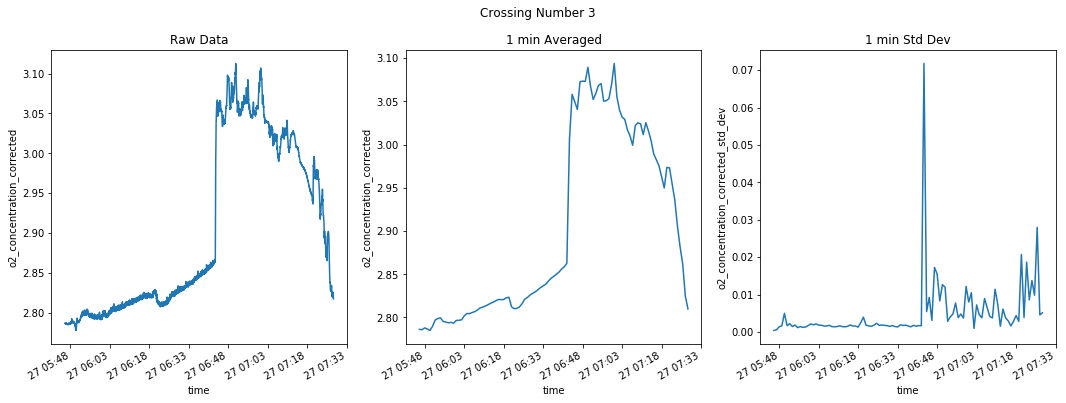

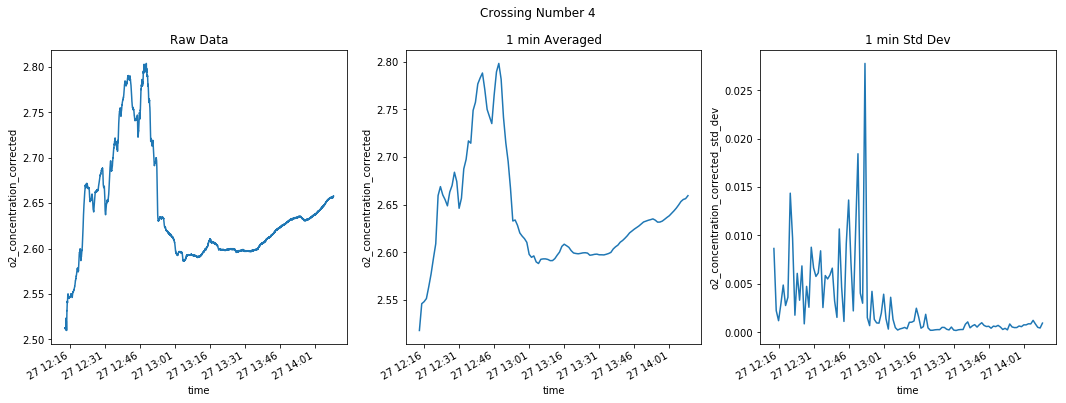

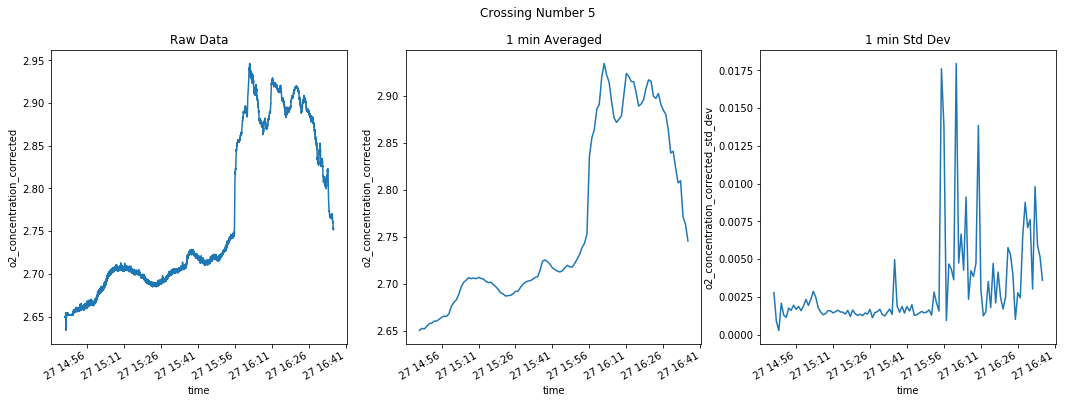

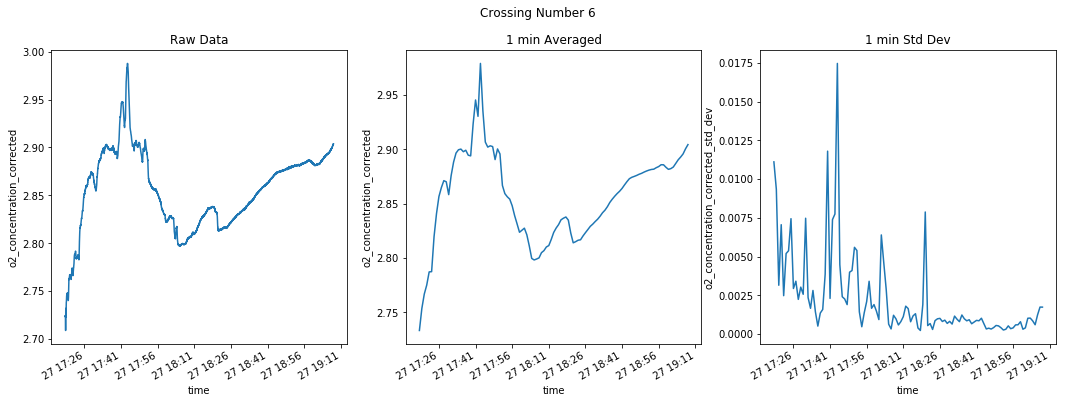

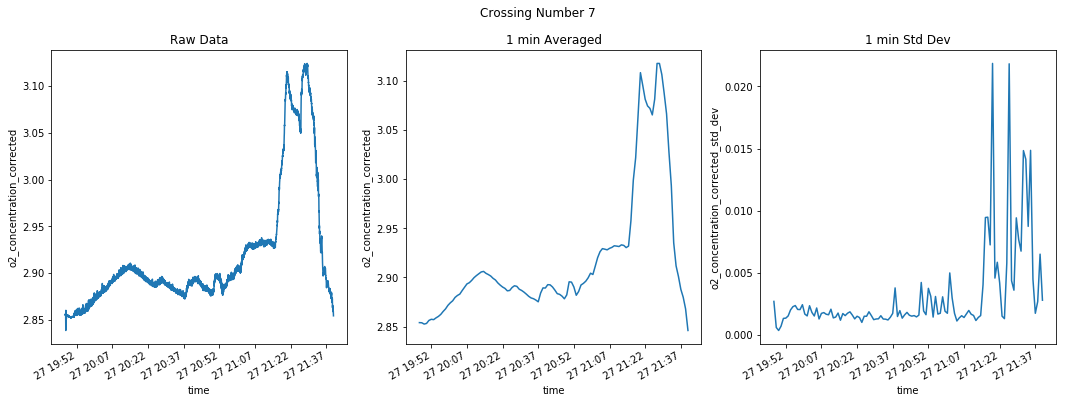

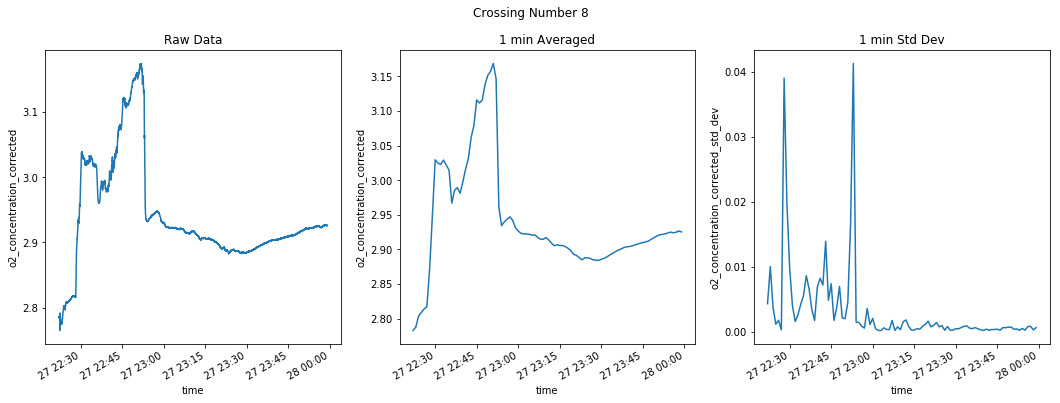

In [101]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    o2_concentration_corrected.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.o2_concentration_corrected[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.o2_concentration_corrected_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### CDOM Fluorescence

<xarray.DataArray 'cdom_fluorescence_sample_count' (time: 1440)>
array([ 56.,  56.,  55., ...,  56.,  56.,  56.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Optical Properties
    standard_name:               mass_fraction_of_cdom_fluorescence_in_sea_wa...
    long_name:                   CDOM fluorescence sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


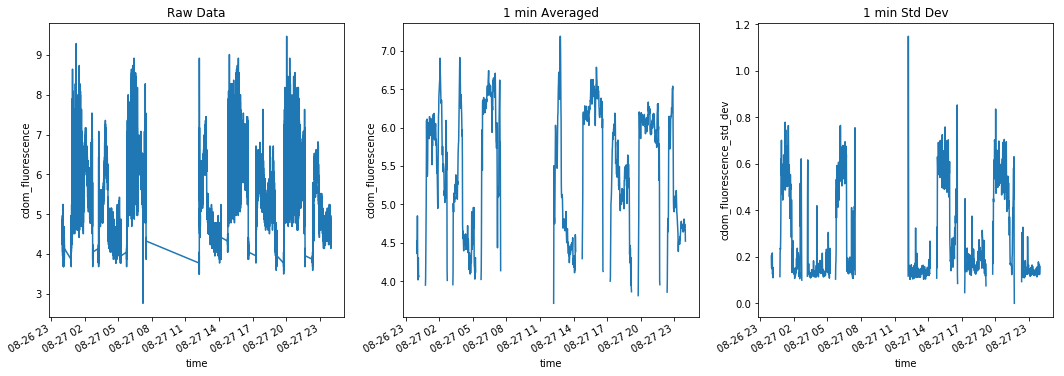

In [87]:
print(ds.cdom_fluorescence_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
cdom_fluorescence.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.cdom_fluorescence.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.cdom_fluorescence_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

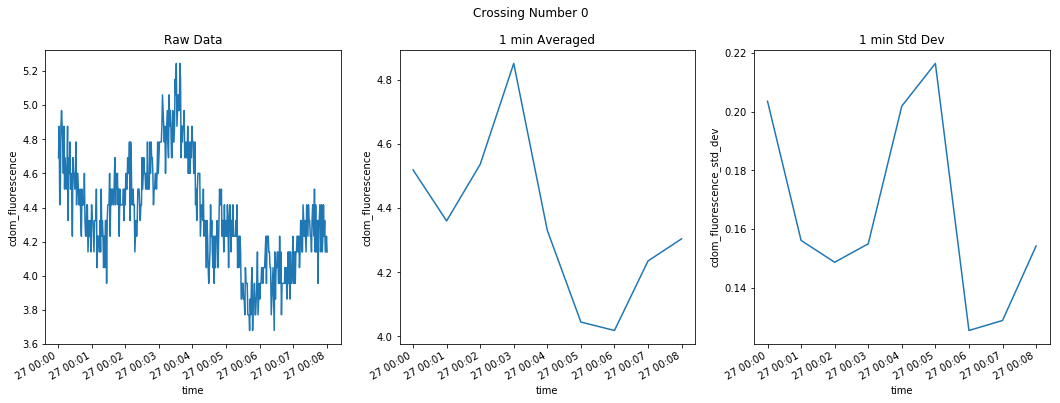

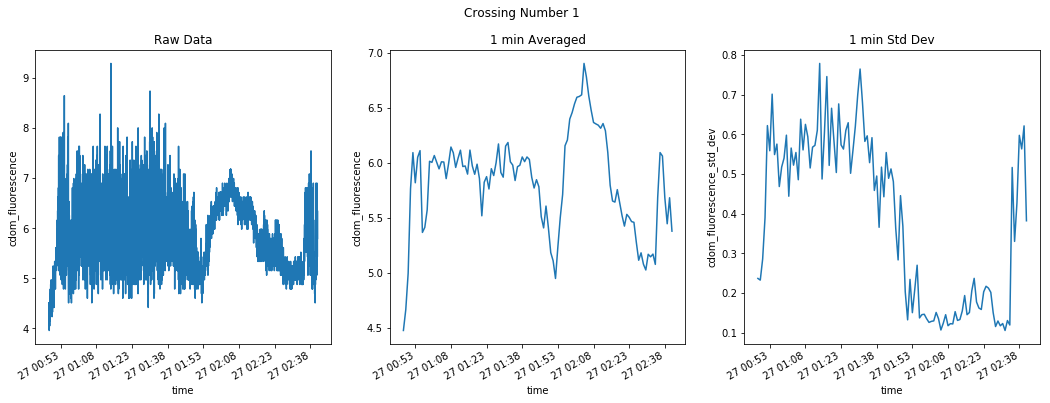

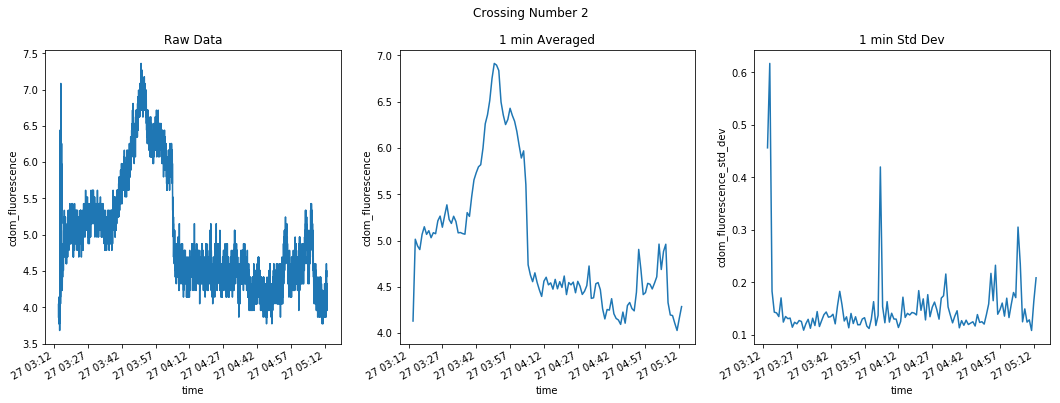

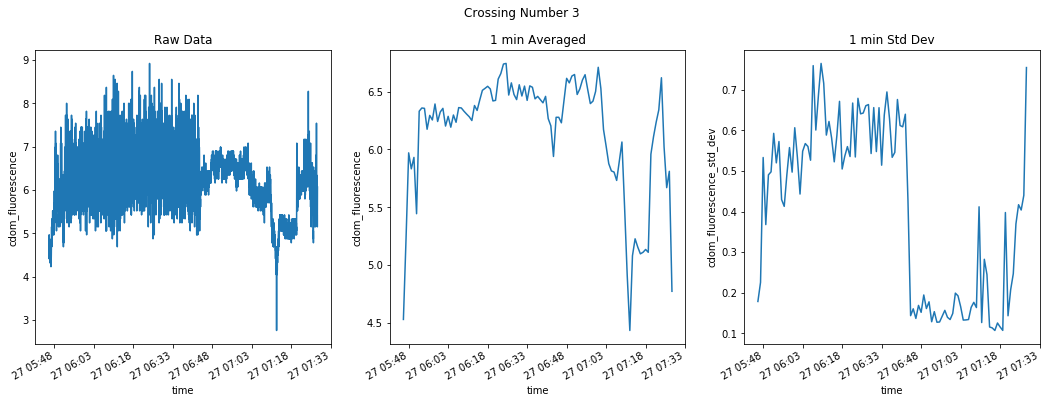

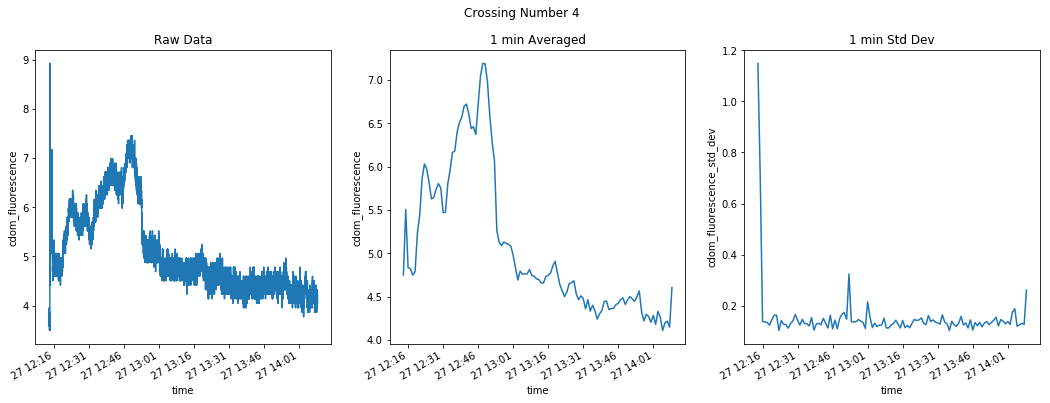

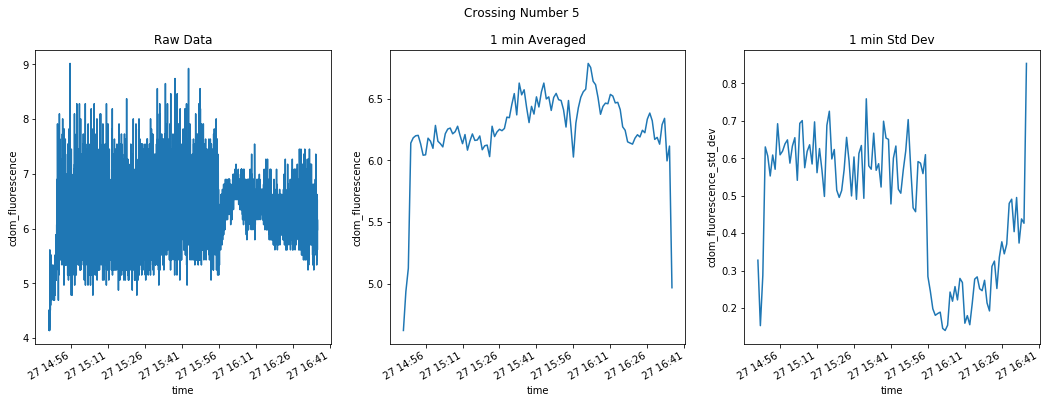

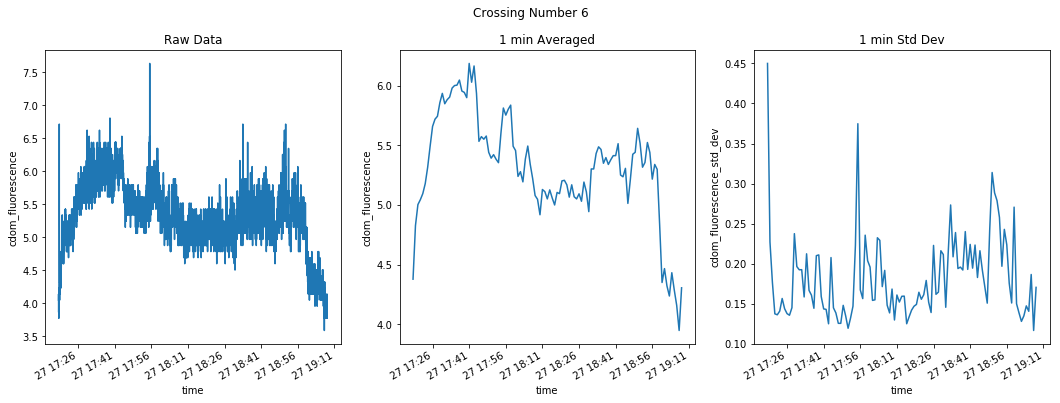

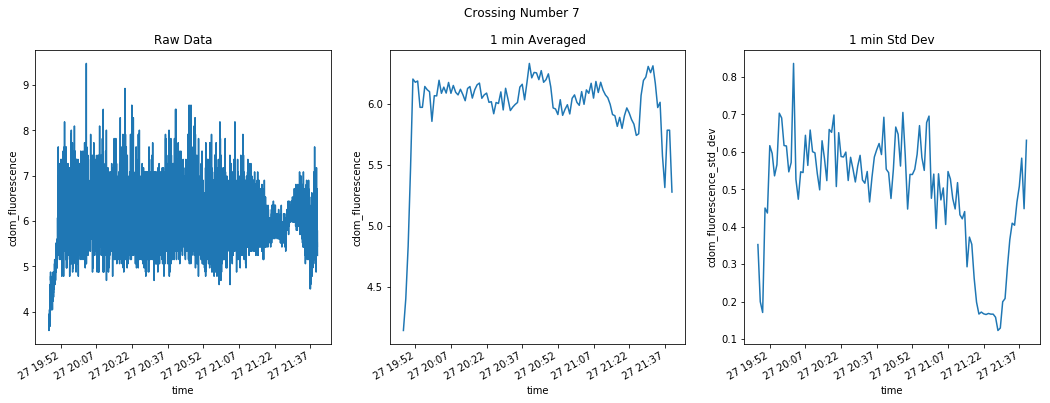

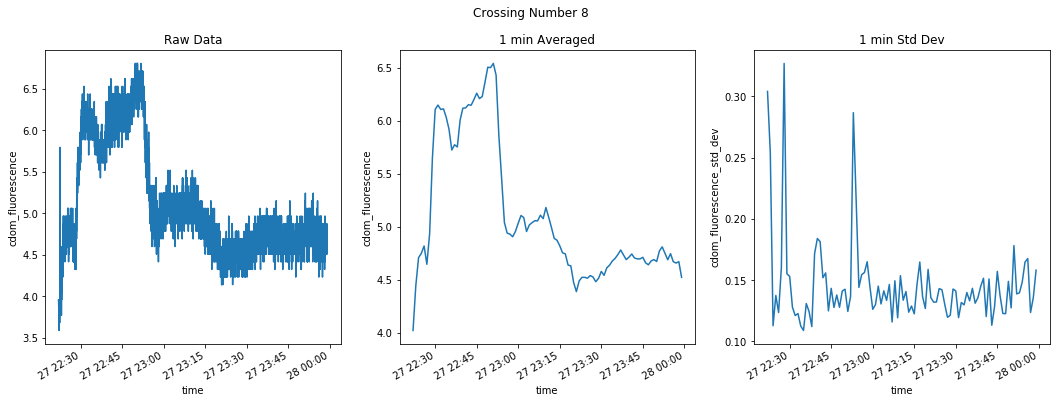

In [88]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    cdom_fluorescence.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.cdom_fluorescence[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.cdom_fluorescence_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Chlorophyll

<xarray.DataArray 'chlorophyll_sample_count' (time: 1440)>
array([ 56.,  56.,  55., ...,  56.,  56.,  56.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Optical Properties
    standard_name:               mass_concentration_of_chlorophyl_in_sea_wate...
    long_name:                   chlorophyll concentration sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


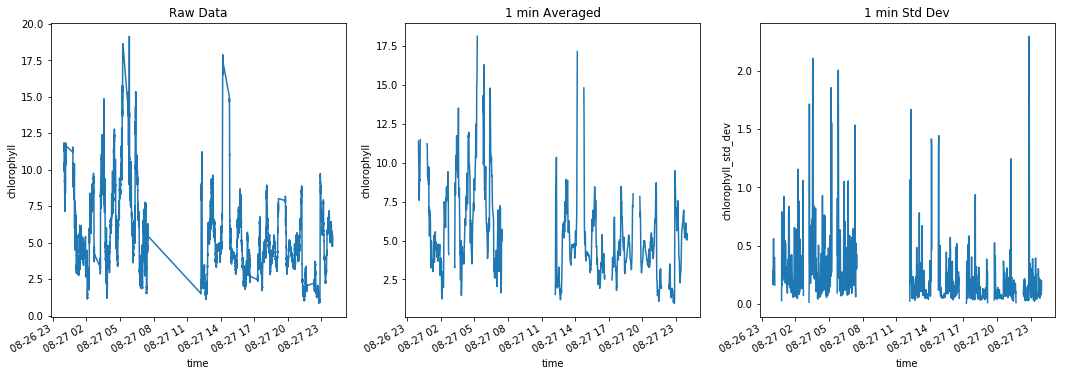

In [89]:
print(ds.chlorophyll_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
chlorophyll.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.chlorophyll.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.chlorophyll_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

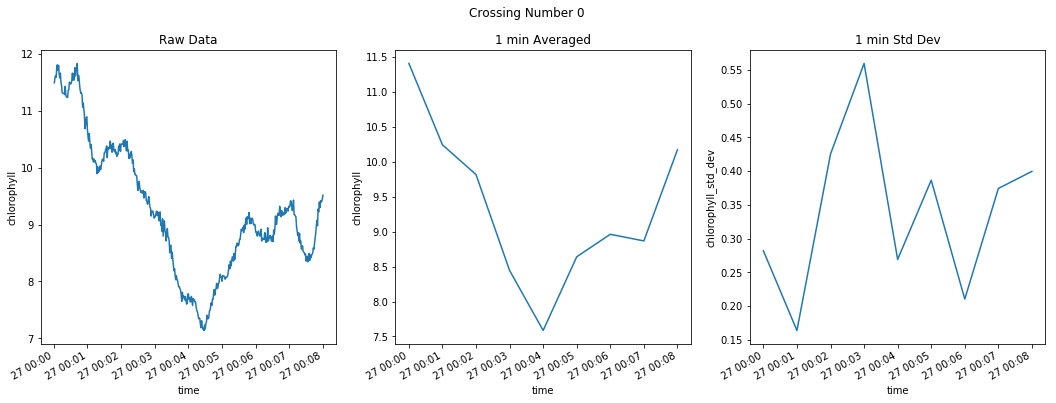

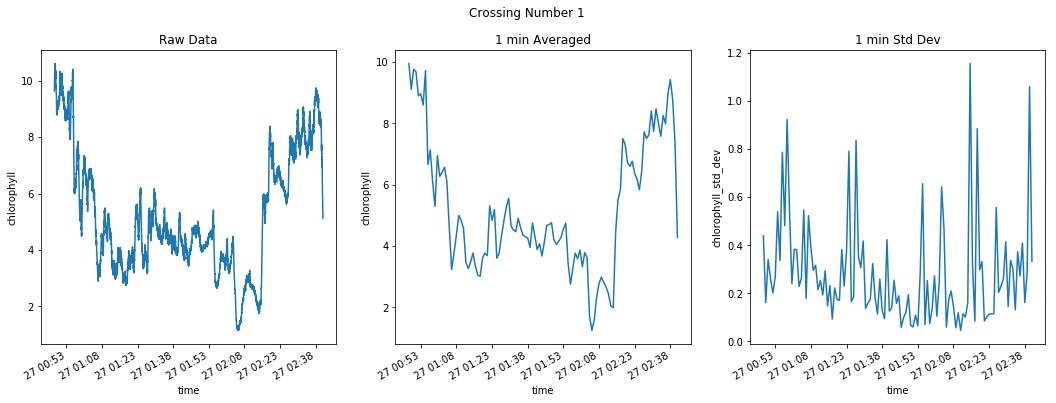

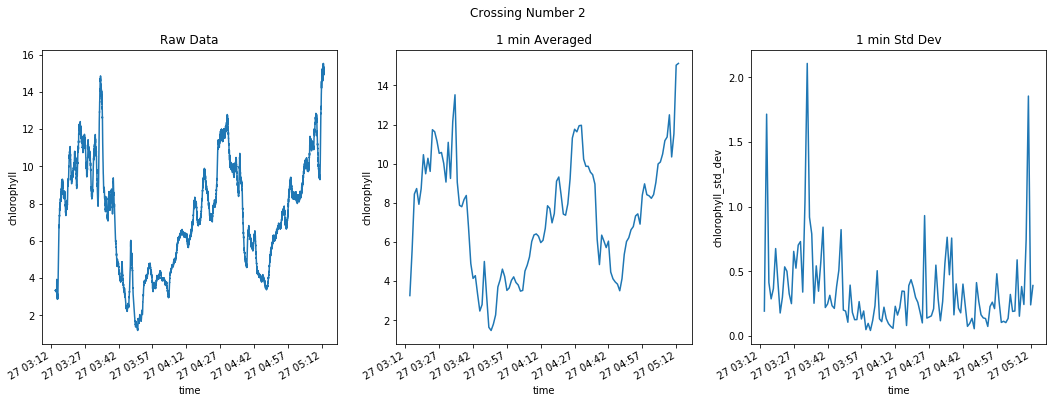

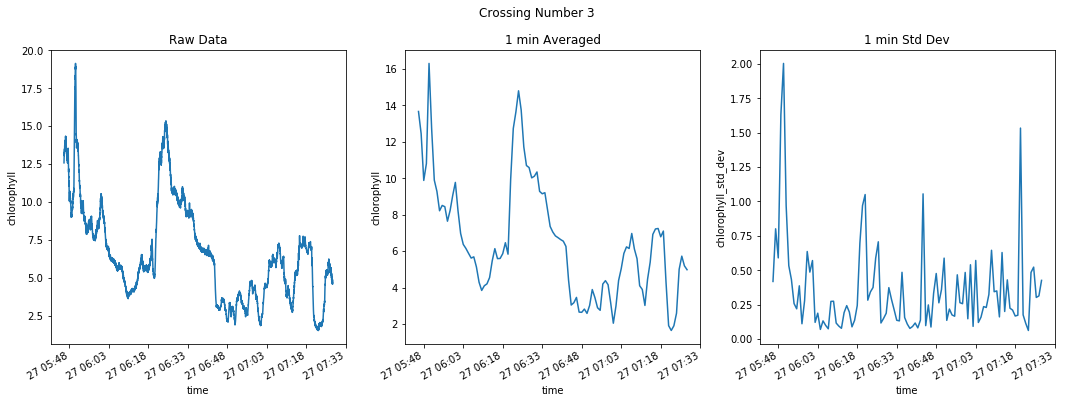

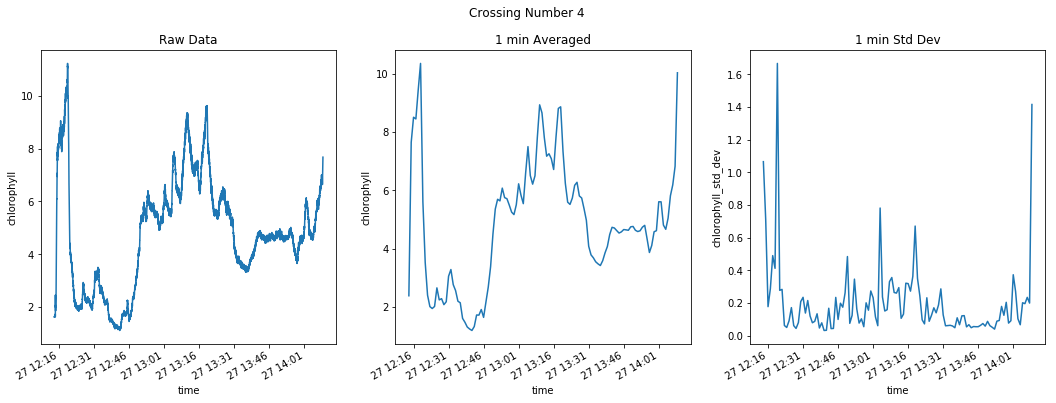

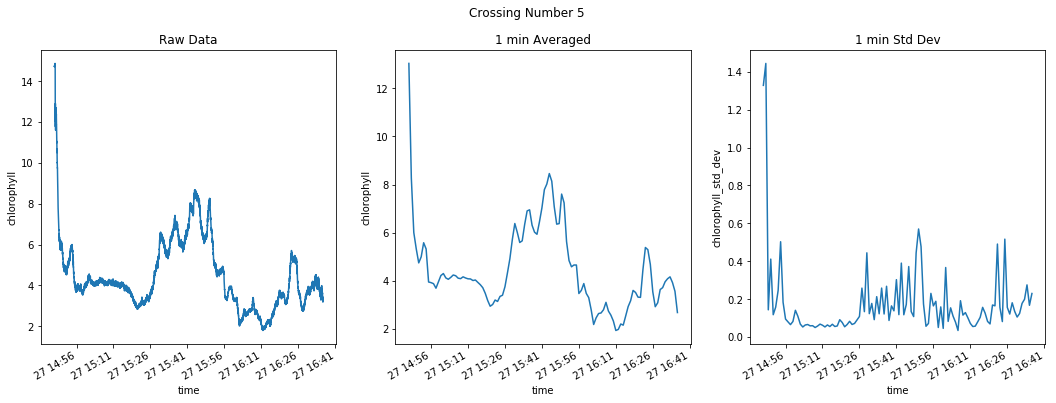

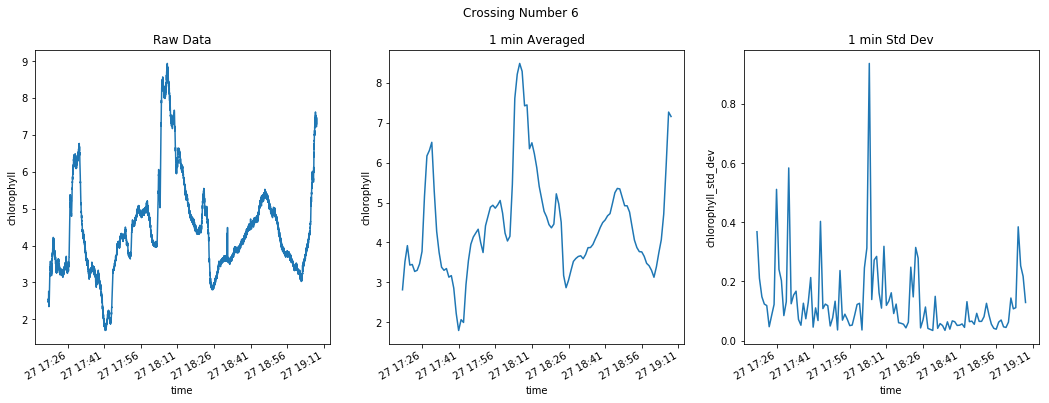

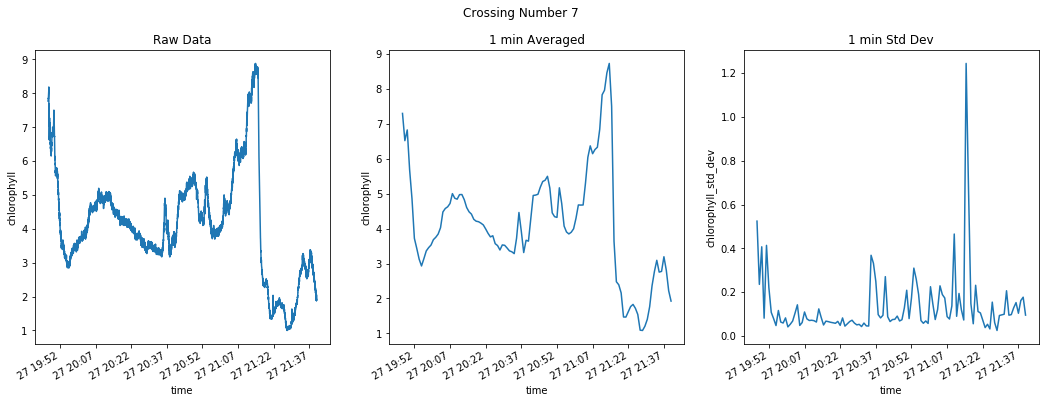

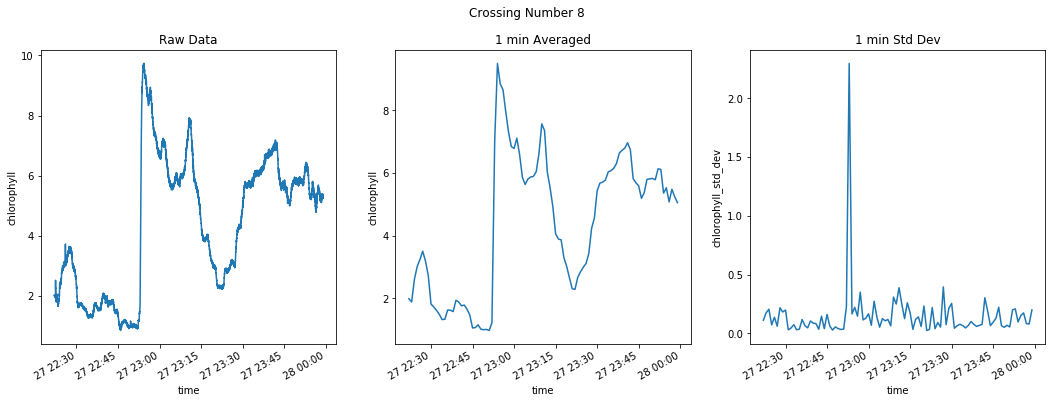

In [90]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    chlorophyll.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.chlorophyll[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.chlorophyll_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Turbidity

<xarray.DataArray 'turbidity_sample_count' (time: 1440)>
array([ 56.,  56.,  55., ...,  56.,  56.,  56.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               Optical Properties
    standard_name:               sea_water_turbidity_sample_count
    long_name:                   turbidity sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


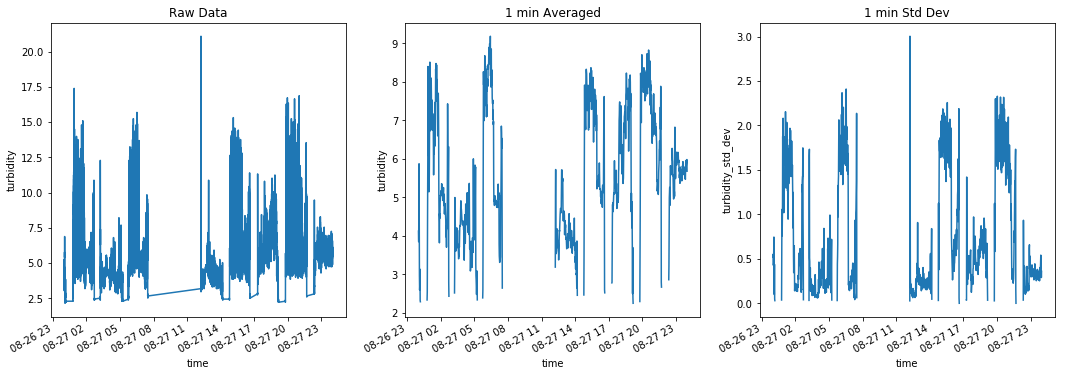

In [91]:
print(ds.turbidity_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
turbidity.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.turbidity.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.turbidity_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

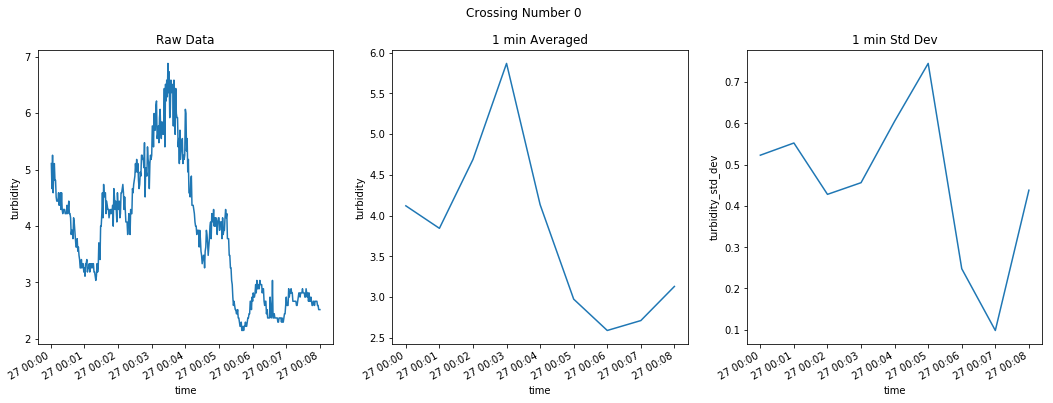

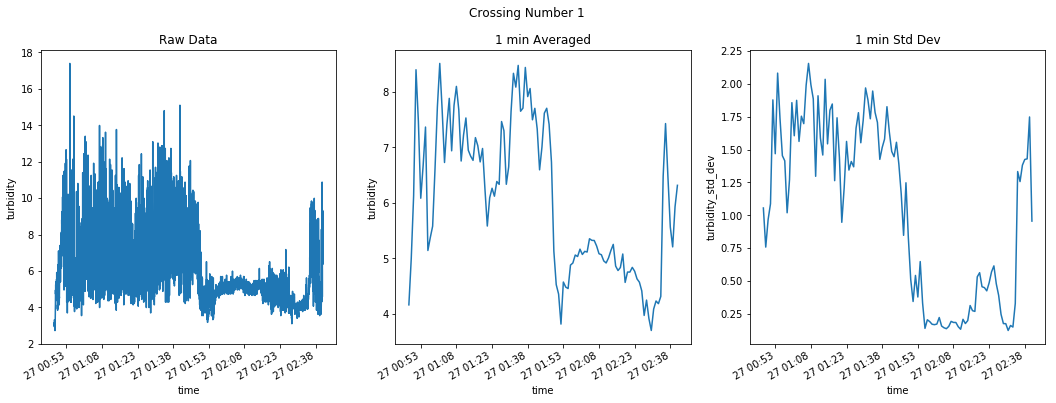

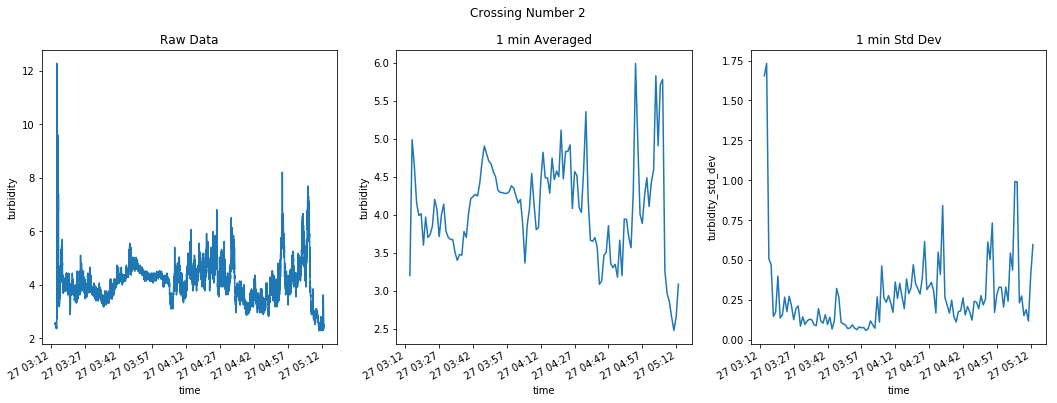

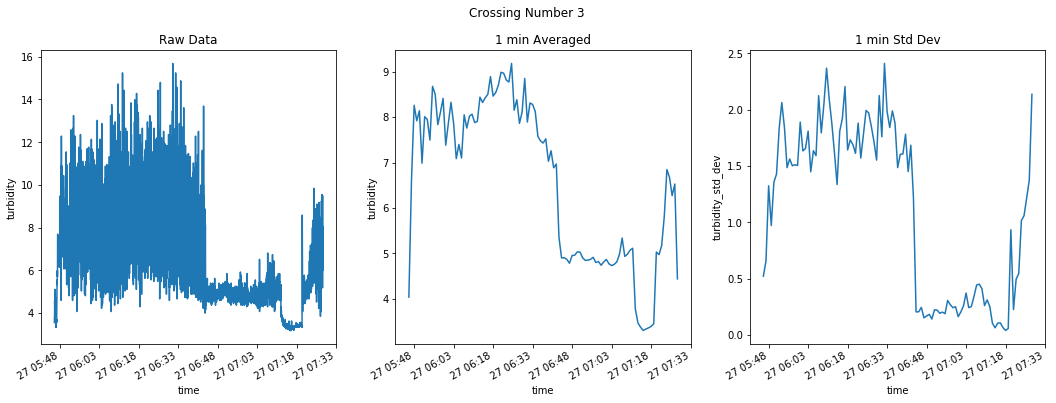

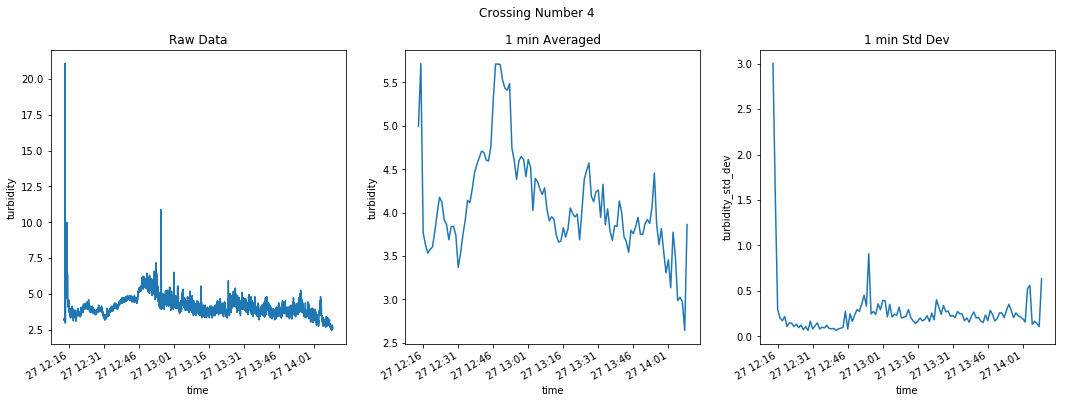

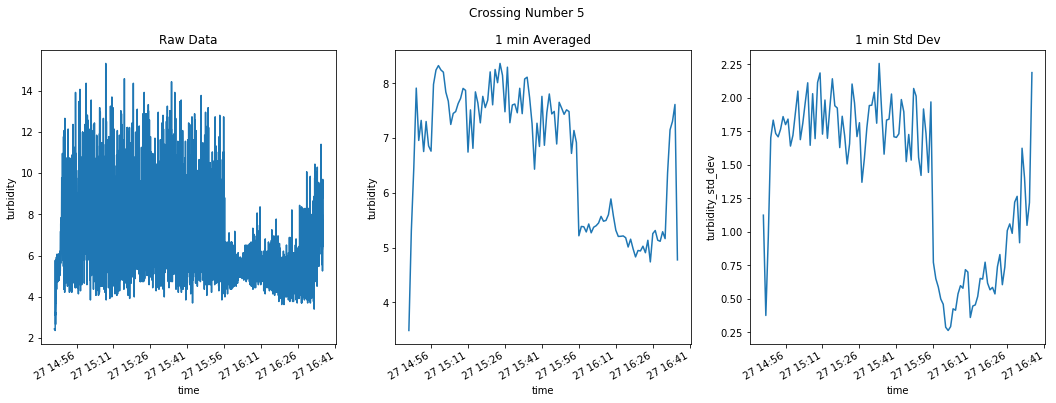

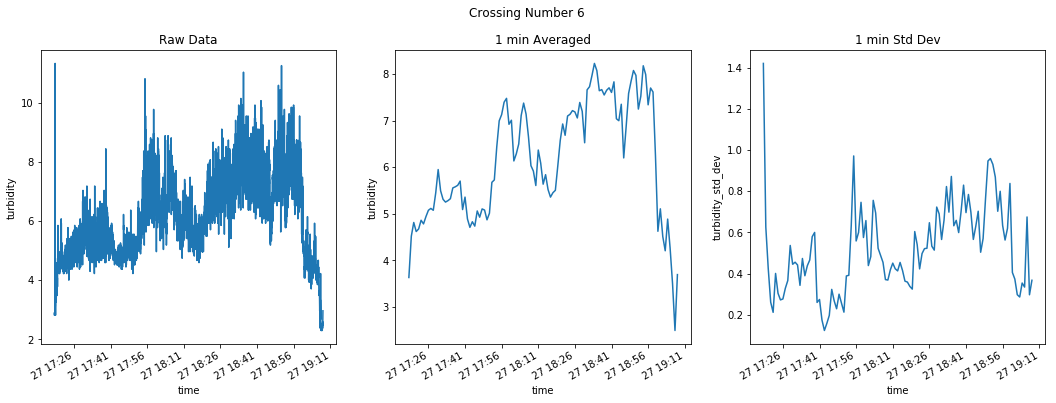

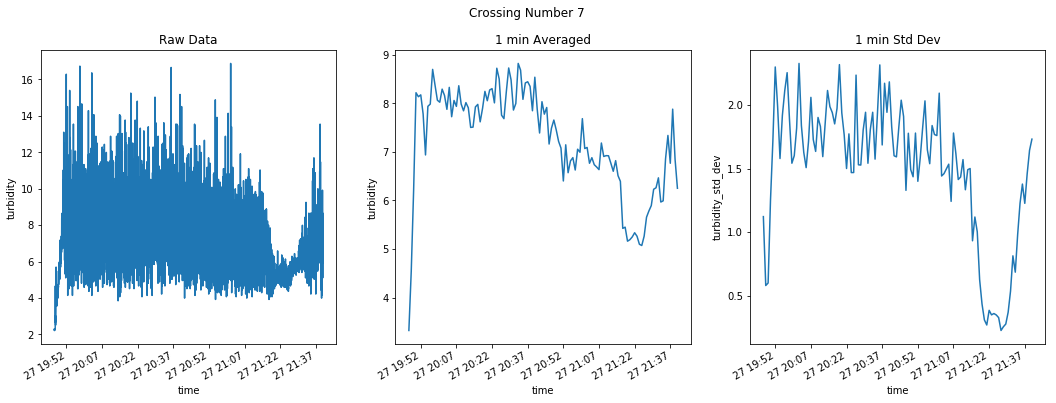

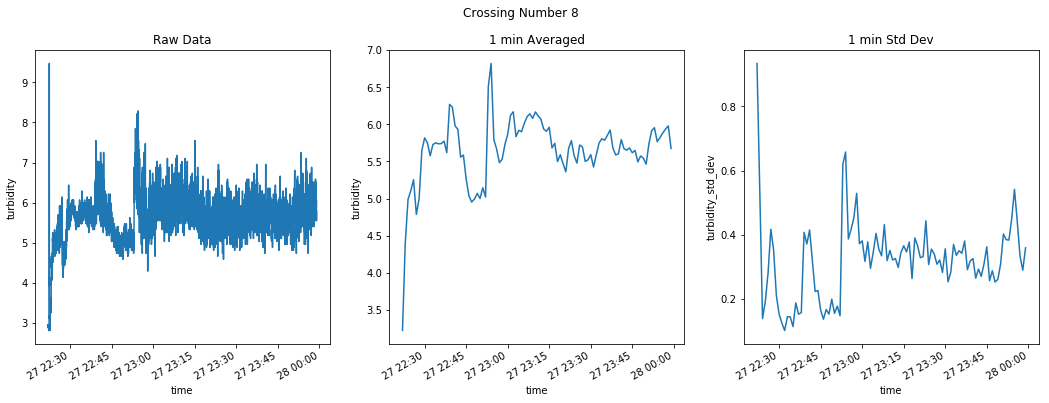

In [92]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    turbidity.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.turbidity[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.turbidity_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### CO2 Partial Pressure

<xarray.DataArray 'co2_partial_pressure_sample_count' (time: 1440)>
array([ 38.,  37.,  38., ...,  38.,  37.,  38.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               CO2
    standard_name:               surface_partial_pressure_of_carbon_dioxide_i...
    long_name:                   CO2 partial pressure sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


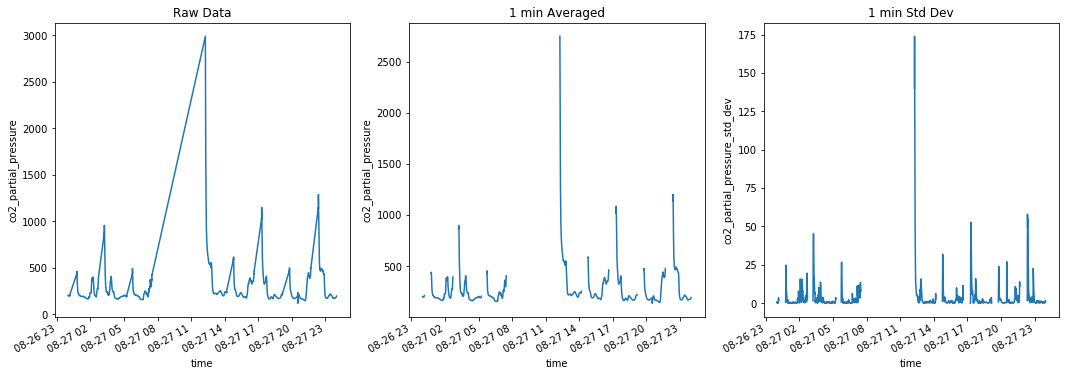

In [93]:
print(ds.co2_partial_pressure_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
co2_partial_pressure.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.co2_partial_pressure.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.co2_partial_pressure_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

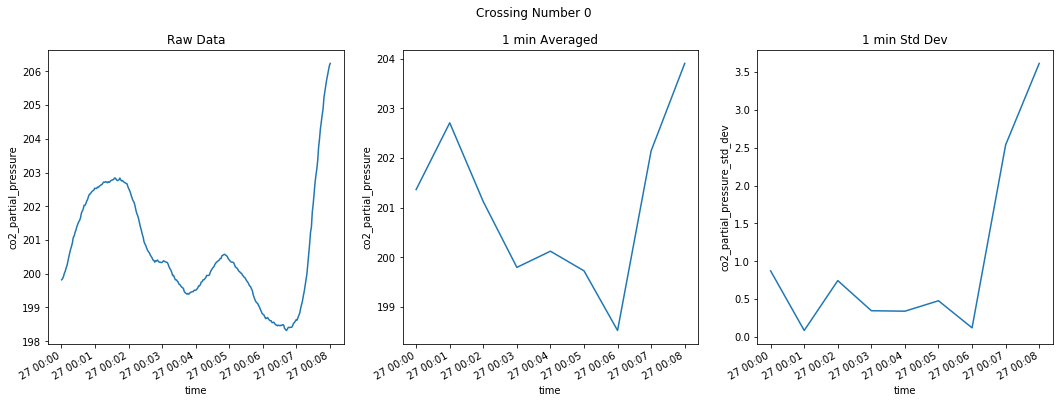

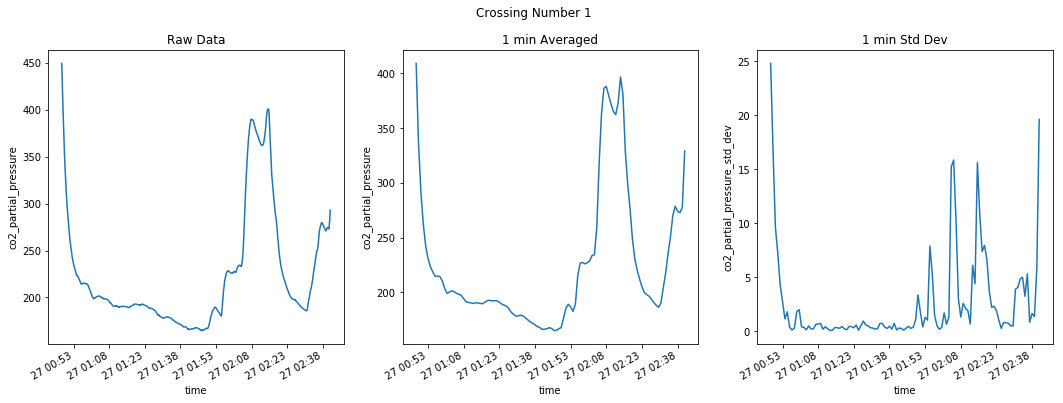

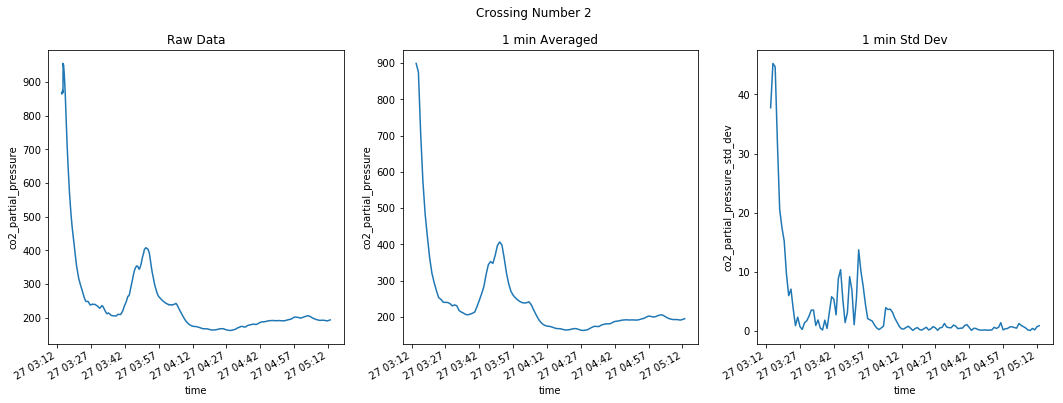

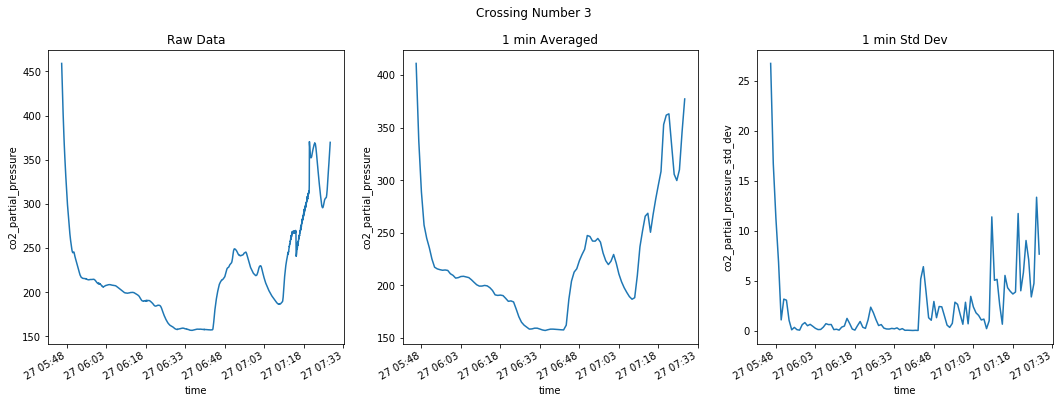

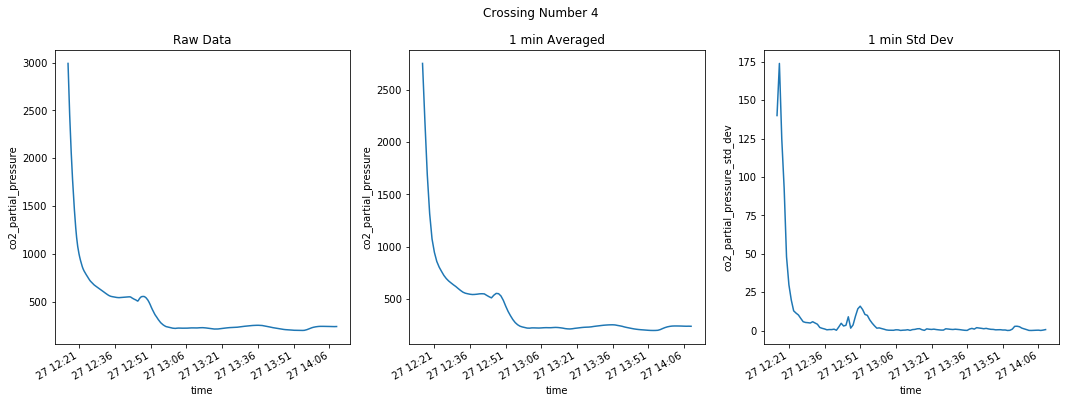

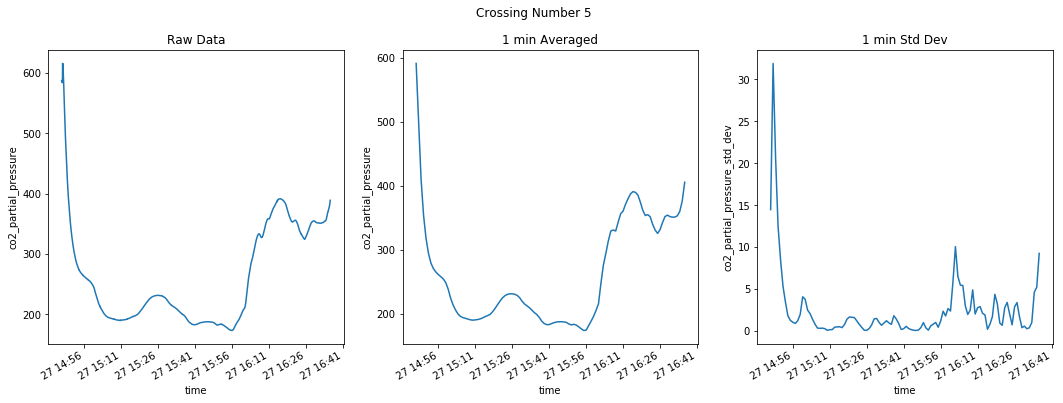

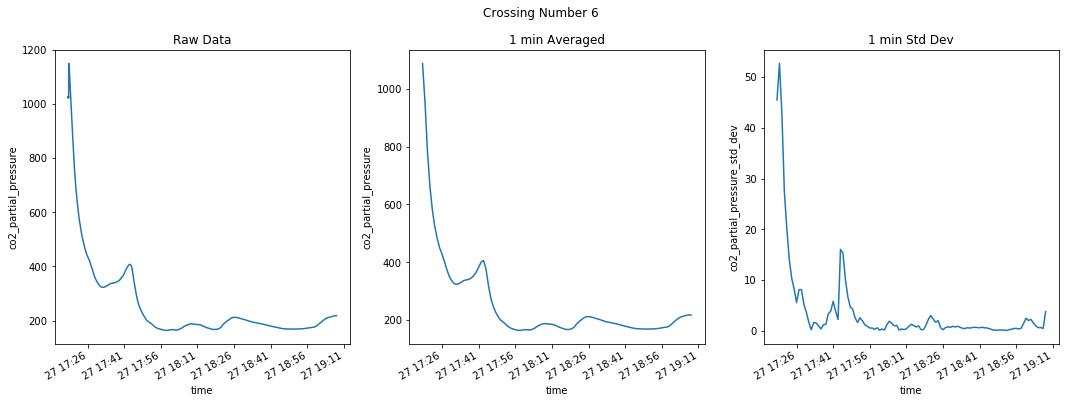

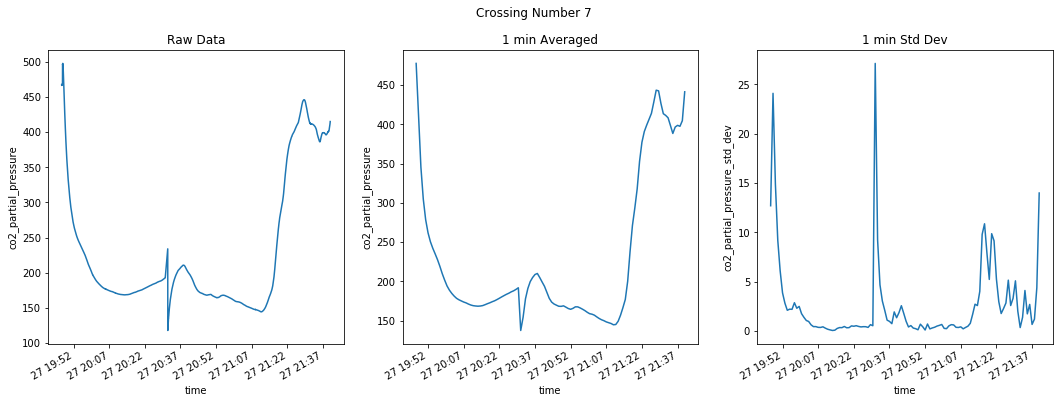

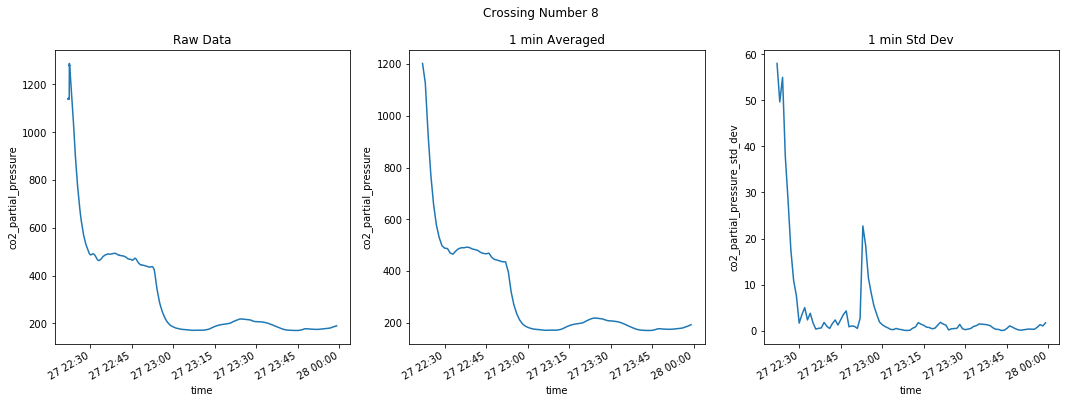

In [94]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    co2_partial_pressure.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.co2_partial_pressure[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.co2_partial_pressure_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

### Linearized CO2 Concentration

<xarray.DataArray 'co2_concentration_linearized_sample_count' (time: 1440)>
array([ 38.,  37.,  38., ...,  38.,  37.,  38.])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-27 2017-08-27T00:01:00 ...
Attributes:
    ioos_category:               CO2
    standard_name:               mole_fraction_of_carbon_dioxide_in_sea_water...
    long_name:                   linearized CO2 concentration sample count
    aggregation_operation:       count
    aggregation_interval:        60
    aggregation_interval_units:  seconds
    ONC_stationCode:             TWDP
    ONC_data_product_url:        http://dmas.uvic.ca/DataSearch?location=TWDP...


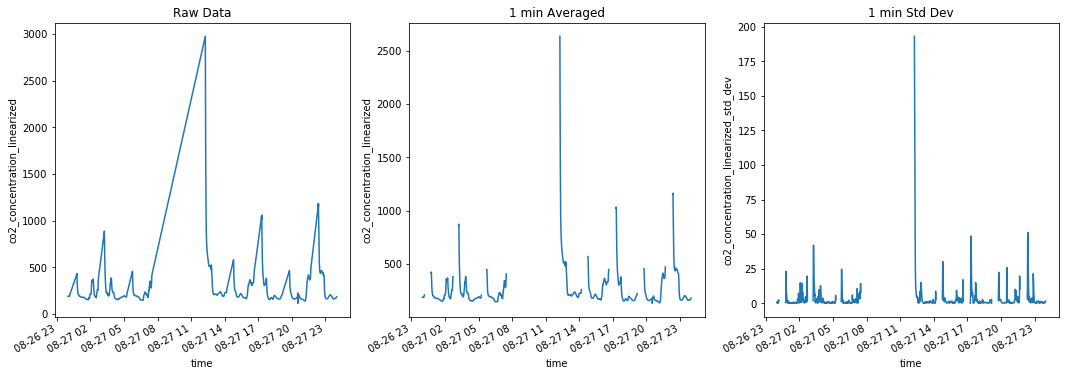

In [95]:
print(ds.co2_concentration_linearized_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
co2_concentration_linearized.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.co2_concentration_linearized.plot(ax=ax2)
ax2.set_title('1 min Averaged')
ds.co2_concentration_linearized_std_dev.plot(ax=ax3)
ax3.set_title('1 min Std Dev')

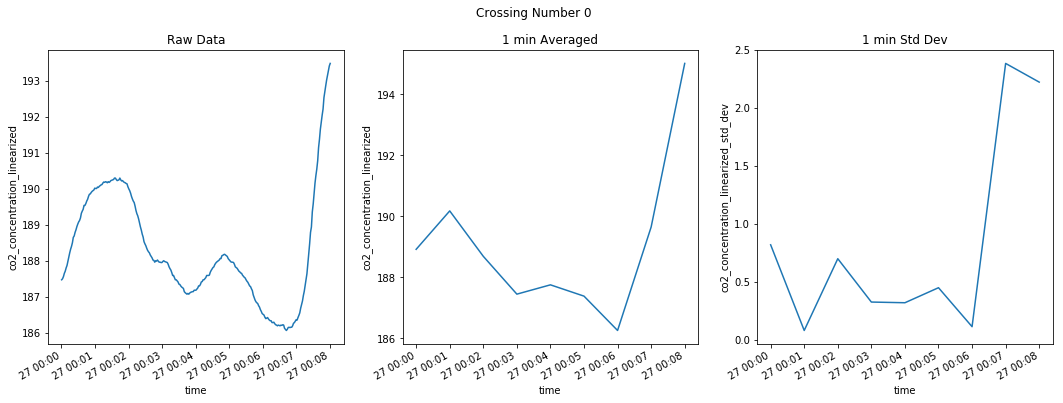

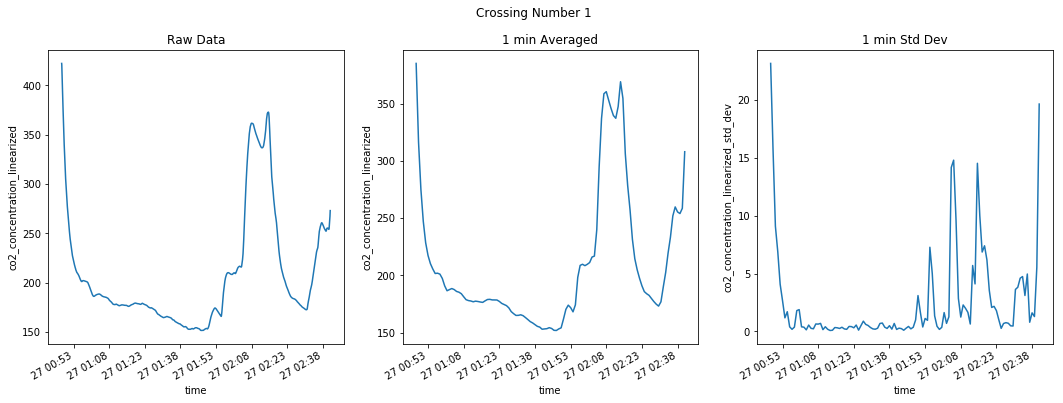

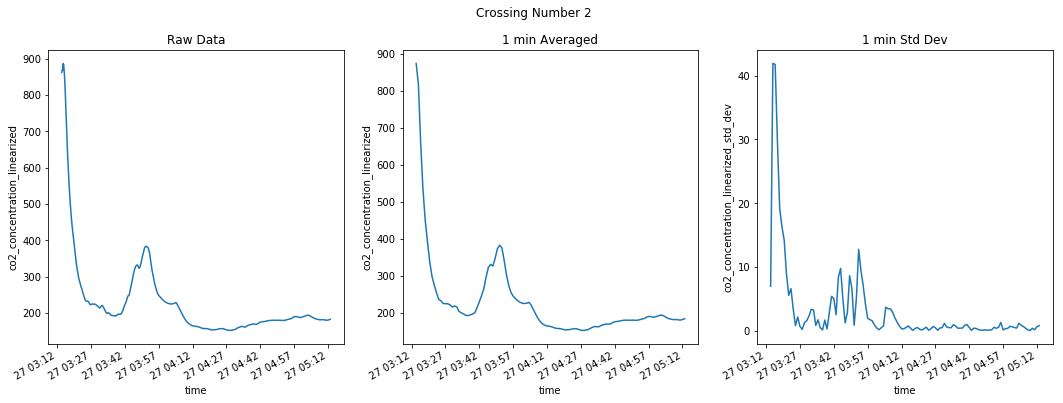

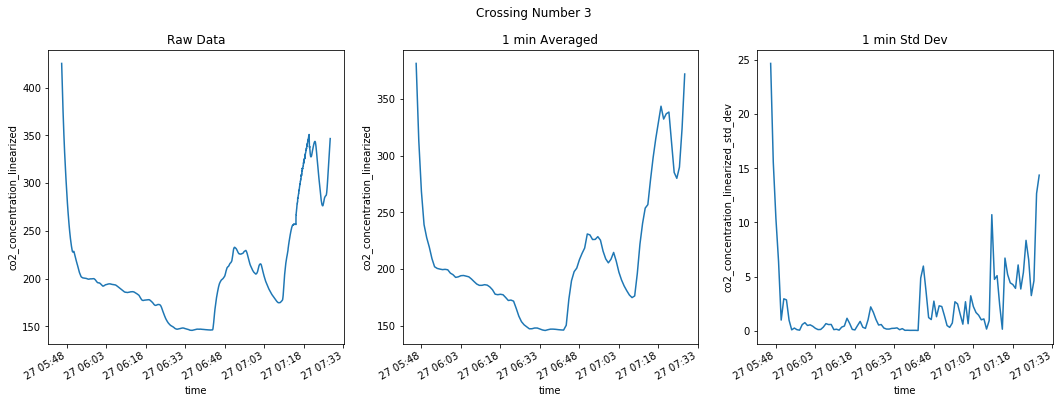

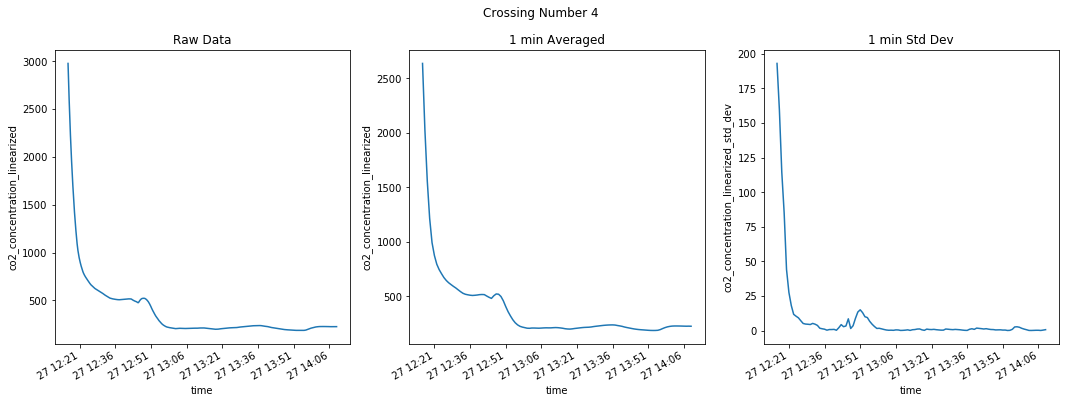

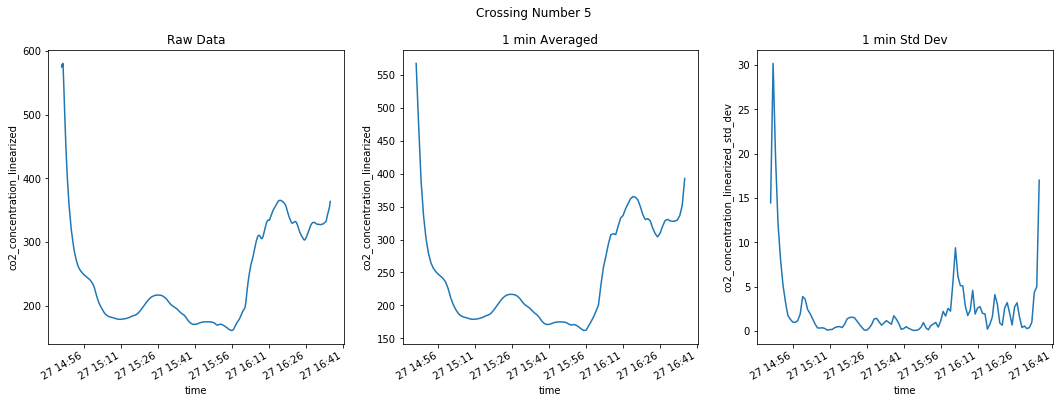

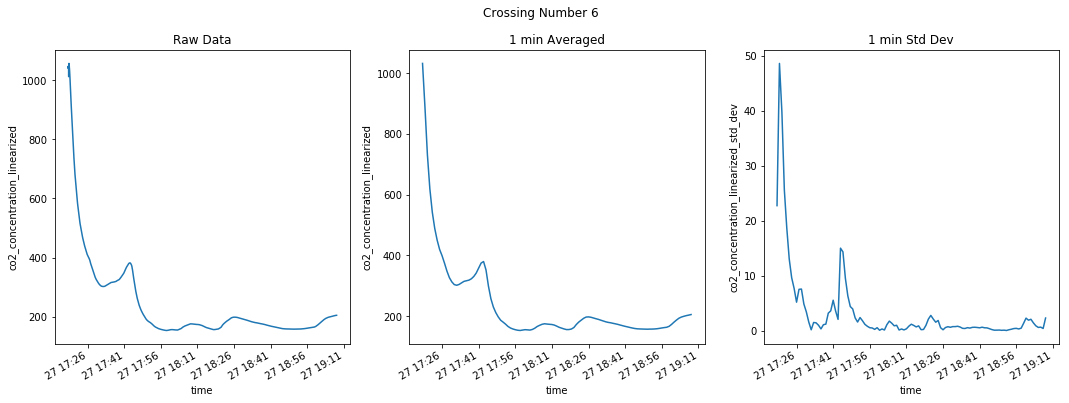

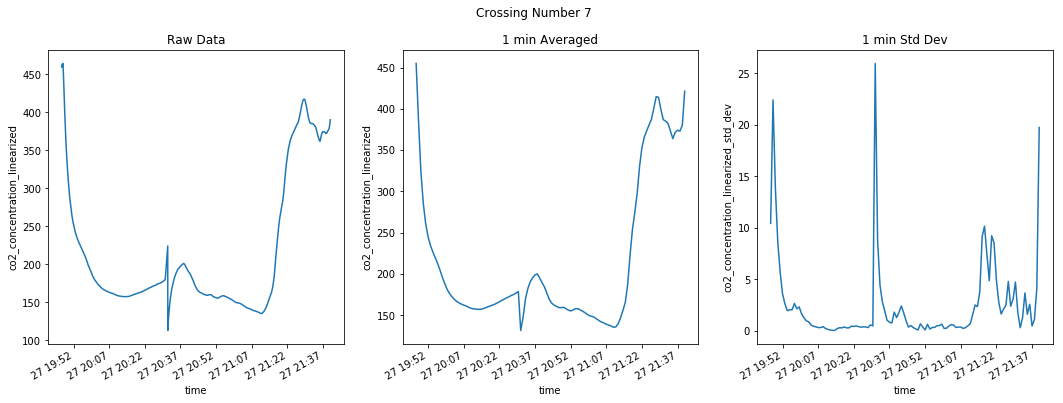

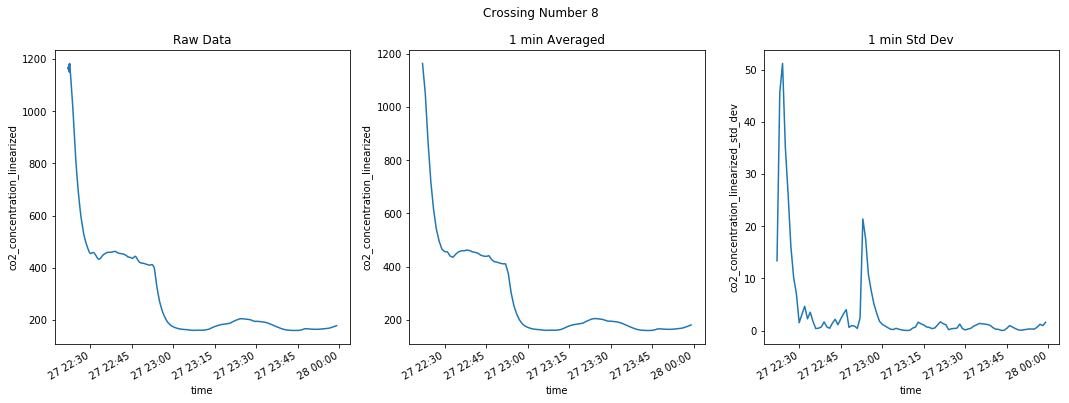

In [96]:
for crossing in range(int(ds.crossing_number.max())+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Crossing Number {crossing}')
    start_end = slice(
        str(ds.time[ds.crossing_number==crossing][0].data), 
        str(ds.time[ds.crossing_number==crossing][-1].data)
    )
    co2_concentration_linearized.sel(time=start_end).plot(ax=ax1)
    ax1.set_title('Raw Data')
    ds.co2_concentration_linearized[ds.crossing_number==crossing].plot(ax=ax2)
    ax2.set_title('1 min Averaged')
    ds.co2_concentration_linearized_std_dev[ds.crossing_number==crossing].plot(ax=ax3)
    ax3.set_title('1 min Std Dev');

## Store the Dataset as a netCDF4 File

ERDDAP requires that all files in a dataset have the same units for their `time` variable.
On the other hand,
`xarray` defaults to using the 1st `time` value in the dataset as the time-base for the units.
So, we have to explicitly define the `time` units as an encoding when the dataset is stored
as a netCDF4 file.

In [97]:
ds.to_netcdf(
    f'/results/observations/ONC/ferries/{onc_station}/'
    f'{onc_station}_TSG_O2_TURBCHLFL_CO2_1m_{data_date.format("YYYYMMDD")}.nc',
    unlimited_dims='time',
    encoding={'time': {'units': 'minutes since 1970-01-01 00:00'}})

## Generate an ERDDAP Dataset XML Fragment

Use the `/opt/tomcat/webapps/erddap/WEB-INF/GenerateDatasetsXml.sh` script
generate the initial version of an XML fragment for a dataset:
```
$ cd /opt/tomcat/webapps/erddap/WEB-INF/
$ bash GenerateDatasetsXml.sh EDDTableFromNcFiles /results/observations/ONC/CTD/SCVIP/
```
The `EDDTableFromNcFiles` and `/results/observations/ONC/CTD/SCVIP/` arguments
tell the script which `EDDType` and what parent directory to use,
avoiding having to type those in answer to prompts.
Answer the remaining prompts,
for example:
```
File name regex (e.g., ".*\.nc") (default="")
? .*SCVIP_CTD_15m_\d{8}\.nc$ 
A sample full file name (default="")
? /results/observations/ONC/CTD/SCVIP/SCVIP_CTD_15m_20160724.nc
DimensionsCSV (or "" for default) (default="")
? 
ReloadEveryNMinutes (e.g., 10080) (default="")
? 10080
PreExtractRegex (default="")
? 
PostExtractRegex (default="")
? 
ExtractRegex (default="")
? 
Column name for extract (default="")
? 
Sorted column source name (default="")
? 
Sort files by sourceName (default="")
? 
infoUrl (default="")
? 
institution (default="")
? 
summary (default="")
? 
title (default="")
?
```

The output is written to `/results/erddap/logs/GenerateDatasetsXml.out`

The `metadata` dictionary below contains information for dataset
attribute tags whose values need to be changed,
or that need to be added for all datasets.

The keys are the dataset attribute names.

The values are dicts containing a required `text` item
and perhaps an optional `after` item.

The value associated with the `text` key is the text content
for the attribute tag.

When present,
the value associated with the `after` key is the name
of the dataset attribute after which a new attribute tag
containing the `text` value is to be inserted.

In [236]:
metadata = OrderedDict([
    ('cdm_data_type', {'text': 'TimeSeries'}),
    ('cdm_timeseries_variables', {
        'text': 'longitude, latitude, on_crossing_mask, crossing_number',
        'after': 'cdm_data_type',
    }),
    ('institution_fullname', {
        'text': 'Earth, Ocean & Atmospheric Sciences, University of British Columbia',
        'after': 'institution',
    }),
    ('license', {
        'text': '''The Salish Sea MEOPAR observation datasets are copyright
by the Salish Sea MEOPAR Project Contributors, The University of British Columbia, and Ocean Networks Canada.

They are licensed under the Apache License, Version 2.0. http://www.apache.org/licenses/LICENSE-2.0

Raw instrument data on which this dataset is based were provided by Ocean Networks Canada.''',
    }),
    ('project', {
        'text':'Salish Sea MEOPAR NEMO Model',
        'after': 'title',
    }),
    ('creator_name', {
        'text': 'Salish Sea MEOPAR Project Contributors',
        'after': 'project',
    }),
    ('creator_email', {
        'text': 'sallen@eos.ubc.ca',
        'after': 'creator_name',
    }),
    ('creator_url', {
        'text': 'https://salishsea-meopar-docs.readthedocs.org/',
        'after': 'creator_email',
    }),
    ('acknowledgement', {
        'text': 'MEOPAR, ONC',
        'after': 'creator_url',
    }),
    ('drawLandMask', {
        'text': 'over',
        'after': 'acknowledgement',
    }),
])

The `datasets` dictionary below provides the content
for the dataset `title` and `summary` attributes.

The `title` attribute content appears in the the datasets list table
(among other places).

The `summary` atribute content appears
(among other places)
when a user hovers the cursor over the `?` icon beside the `title`
content in the datasets list table.
The text that is inserted into the `summary` attribute tag
by code later in this notebook is the
`title` content followed by the `summary` content,
separated by a blank line.

The keys of the `datasets` dict are the `datasetID` strings that
are used in many places by the ERDDAP server.
They are structured as follows:

* `ubc` to indicate that the dataset was produced at UBC
* `ONC` to indicate that the dataset is a product of filter, resampling, etc.
raw instrument data provided by Ocean Networks Canada (ONC)
* a description of the dataset variables; e.g. `TWDP`
* the time interval of values in the dataset; e.g. `1m`
* the dataset version; e.g. `V1`

So:

* `ubcONCTWDP1mV1` is the version 1 dataset of 1 minute resampled ferry data
from the ONC Mobile Platforms, British Columbia Ferries, Tsawwassen - Duke Point route

The dataset version part of the `datasetID` is used to indicate changes in the variables
contained in the dataset.

All datasets start at `V1` and their `summary` ends with a notation about the variables
that they contain; e.g.
```
v1: on_crossing_mask, crossing_number,
temperature, temperature standard deviation, temperature sample counts,
conductivity, conductivity standard deviation, conductivity sample counts,
reference salinity, reference salinity standard deviation, reference salinity sample counts
```
When the a dataset version is incremented a line describing the change is added
to the end of its `summary`.

In [250]:
datasets = {
    'ubcONCTWDP1mV1' :{
        'type': 'resampled TSG, O2, TURBCHLFL, CO2',
        'title': 'ONC, Strait of Georgia, BC Ferries, Tsawwassen - Duke Point, 1min, v1',
        'summary':'''Data from the Ocean Networks Canada (ONC)
Strait of Georgia Mobile Platforms, British Columbia Ferries, Tsawwassen - Duke Point route.
The data are resampled from the raw instrument data to 1 minute mean values.
They are accompanied by standard deviations and sample counts for each of the 1 minute
aggregation intervals.

v1: on_crossing_mask, crossing_number,
    temperature, temperature standard deviation, temperature sample counts,
    conductivity, conductivity standard deviation, conductivity sample counts,
    reference salinity, reference salinity standard deviation, reference salinity sample counts variables''',
        'keywords': '''1min aggregation, ONC Mobile Platforms, British Columbia Ferries, 
Tsawwassen - Duke Point route, Ocean Networks Canada,
UBC EOAS, Strait of Georgia, latitude, longitude, ocean, observations,
Oceans &gt; Ocean Temperature &gt; Water Temperature,
Oceans &gt; Salinity/Density &gt; Conductivity,
conductivity, conductivity_sample_count, conductivity_std_dev, electrical conductivity, 
reference salinity, salinity_sample_count, salinity_std_dev, sea water, 
sea water electrical conductivity, sea_water_electrical_conductivity, 
sea_water_electrical_conductivity_sample_count, sea_water_electrical_conductivity_standard_deviation, 
sea_water_reference_salinity, sea_water_reference_salinity_sample_count, 
sea_water_reference_salinity_standard_deviation, 
sea_water_temperature, sea_water_temperature_sample_count, sea_water_temperature_standard_deviation, 
temperature, temperature_sample_count, temperature_std_dev, time''',
        'fileNameRegex': '.*TWDP_TSG_O2_TURBCHLFL_CO2_1m_\d{8}.nc$'
    },
}

A few convenience functions to reduce code repetition:

In [251]:
def print_tree(root):
    """Display an XML tree fragment with indentation.
    """
    print(etree.tostring(root, pretty_print=True).decode('ascii'))

In [252]:
def find_att(root, att):
    """Return the dataset attribute element named att
    or raise a ValueError exception if it cannot be found.
    """
    e = root.find('.//att[@name="{}"]'.format(att))
    if e is None:
        raise ValueError('{} attribute element not found'.format(att))
    return e

* parse the output of `GenerateDatasetsXml.sh` into an XML tree data structure
* set the `datasetID` dataset attribute value
* change the `recursive` dataset attribute value to `false`
* re-set the `fileNameRegex` dataset attribute value because it looses its `\` characters during parsing(?)
* add a `cf_role` attribute element with value `timeseries_id` to the `time` variable
* update the metadata elements with the contents of the `datasets` dict defined above
* set the colour map limit variables for the variables that they make sense for,
and delete from the variables for which they are nonsensical

In [266]:
parser = etree.XMLParser(remove_blank_text=True)
tree = etree.parse('/results/erddap/logs/GenerateDatasetsXml.out', parser)
root = tree.getroot()

datasetID = 'ubcONCTWDP1mV1'

In [267]:
root.attrib['datasetID'] = datasetID
root.find('.//recursive').text = 'false'
root.find('.//fileNameRegex').text = datasets[datasetID]['fileNameRegex']

In [268]:
vars = [e.text for e in tree.findall('//sourceName')]
vars

['time',
 'longitude',
 'latitude',
 'on_crossing_mask',
 'crossing_number',
 'temperature',
 'temperature_std_dev',
 'temperature_sample_count',
 'conductivity',
 'conductivity_std_dev',
 'conductivity_sample_count',
 'salinity',
 'salinity_std_dev',
 'salinity_sample_count']

In [269]:
e = etree.Element('att', name='cf_role')
e.text = 'timeseries_id'
tree.find('//dataVariable[{}]/addAttributes'.format(vars.index('time')+1)).append(e)

In [270]:
for att, info in metadata.items():
    e = etree.Element('att', name=att)
    e.text = info['text']
    try:
        root.find('.//att[@name="{}"]'.format(info['after'])).addnext(e)
    except KeyError:
        find_att(root, att).text = info['text']

In [271]:
title = datasets[datasetID]['title']
find_att(root, 'title').text = title
find_att(root, 'infoUrl').text = 'https://salishsea-meopar-tools.readthedocs.org/en/latest/results_server/'
find_att(root, 'institution').text = 'UBC EOAS'
find_att(root, 'summary').text = '{0}\n\n{1}'.format(title, datasets[datasetID]['summary'])
try:
    find_att(root, 'keywords').text = datasets[datasetID]['keywords']
except KeyError:
    pass

attrs = root.find('addAttributes')
etree.SubElement(attrs, 'att', name='history').text = 'null'

In [272]:
# Crossing number colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('crossing_number')+1))
e.text = '0.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('crossing_number')+1))
e.text = '10.0'

# Temperature colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('temperature')+1))
e.text = '4.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('temperature')+1))
e.text = '20.0'

# Conductivity colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('conductivity')+1))
e.text = '0.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('conductivity')+1))
e.text = '5.0'

# Salinity colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('salinity')+1))
e.text = '0.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('salinity')+1))
e.text = '34.0'

In [273]:
# Delete nonsensical colourBar* attributes
no_cbar_vars = [
    'on_crossing_mask',
    'temperature_sample_count', 'temperature_std_dev',
    'conductivity_sample_count', 'conductivity_std_dev',
    'salinity_sample_count', 'salinity_std_dev']
for var in no_cbar_vars:
    for att in ('colorBarMinimum', 'colorBarMaximum'):
        e = tree.find(
            '//dataVariable[{0}]/addAttributes/att[@name="{1}"]'
            .format(vars.index(var)+1, att))
        e.getparent().remove(e)

Inspect the resulting dataset XML fragment below and edit the dicts and
code cell above until it is what is required for the dataset:

In [274]:
print_tree(root)

<dataset type="EDDTableFromNcFiles" datasetID="ubcONCTWDP1mV1" active="true">
  <reloadEveryNMinutes>10080</reloadEveryNMinutes>
  <updateEveryNMillis>10000</updateEveryNMillis>
  <fileDir>/results/observations/ONC/ferries/TWDP/</fileDir>
  <recursive>false</recursive>
  <fileNameRegex>.*TWDP_TSG_O2_TURBCHLFL_CO2_1m_\d{8}.nc$</fileNameRegex>
  <metadataFrom>last</metadataFrom>
  <preExtractRegex/>
  <postExtractRegex/>
  <extractRegex/>
  <columnNameForExtract/>
  <sortedColumnSourceName>time</sortedColumnSourceName>
  <sortFilesBySourceNames>time</sortFilesBySourceNames>
  <fileTableInMemory>false</fileTableInMemory>
  <accessibleViaFiles>false</accessibleViaFiles>
  <!-- sourceAttributes>
        <att name="_NCProperties">version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.8.18</att>
        <att name="ferry_route_name">Tsawwassen - Duke Point</att>
        <att name="history">2017-08-24 12:31:58 Download raw data from ONC scalardata API.
2017-08-24 12:31:58 Filter to exclude data wi

Store the XML fragment for the dataset:

In [275]:
with open('/results/erddap-datasets/fragments/{}.xml'.format(datasetID), 'wb') as f:
    f.write(etree.tostring(root, pretty_print=True))

Edit `/opt/tomcat/content/erddap/datasets.xml` to include the XML fragment for the dataset that was stored by the abave cell.

Create a flag file to signal the ERDDAP server process to load the dataset:
```bash
$ cd /results/erddap/flag/
$ touch <datasetID>
```

Confirm that the dataset and its metadata were correctly added to ERDDAP by inspecting
https://salishsea.eos.ubc.ca/erddap/tabledap/.
If there is a problem,
error messages can be found in `/results/erddap/logs/log.txt`.